# Description

This notebook makes use of the **pandas** library and the **ete3 toolkit**, specifically ete3's [NCBI Taxonomic database](http://etetoolkit.org/docs/latest/tutorial/tutorial_ncbitaxonomy.html). Several custom functions simplifying the use of ete3 are in the zoonosis_helper_functions.py script which is imported into the notebook.


The primary data is obtained from the Uniprot database. It contains data on proteins which facilitate viral [entry into host cells](https://www.uniprot.org/uniprot/?query=keyword:%22Virus%20entry%20into%20host%20cell%20[KW-1160]%22). The data is in 2 parts, the first being the [tabular data](#tabular-data) and the second being the [fasta sequences](#fasta) of the virus surface proteins. The 2 are linked by their uniprot entry identifiers. A very small portion of the data has been reviewed and is not sufficient for application in deep learning so both the reviewed and unreviewed data is kept, however, the unreviewed data lacks information on host data.

To alleviate the host data information, external sources were used, namely:

- [NCBI Virus database](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?VirusLineage_ss=Viruses,%20taxid:10239&SeqType_s=Protein&Proviral_s=exclude&HostLineage_ss=Mammalia%20(mammals),%20taxid:40674)
- [Virus-Host database](https://www.genome.jp/virushostdb/)
- [Enhanced Infectious Disease Database (EID2)](https://eid2.liverpool.ac.uk/OrganismInteractions)

1. [The ete3 is first used to obtain taxomomic identifiers at the species level and if an identifier is already present to still use the ete3 taxonomic identifiers for consistency.](#ete3-taxo)

1. [Data is further filtered to keep only viruses (organism).](#filter)

1. [The dataset contains some repetitive information i.e. same virus, same hosts but different protein or different protein entry. Therefore, the next step was to fill in the host data using information from the reviewed data. The premise was if it's the same virus then it ought to have the same hosts.](#Updating-host-names-from-other-host-data-in-the-dataset)

1. [Thereafter information form external sources is appended to the primary data. Missing data after final processing is dropped.](#Updating-host-names-from-external-sources)

1. [An additional column (Infects human) is then later added. If at least one of the virus hosts is homo sapiens then an assignment of **1** is given otherwise **0** is assigned to the row.](#Further-Processing)

1. [Since the data was obtained from multiple sources further processing was done to make the information format consistent.](#host-name-consistency)

1. [The sequence data is loaded and linked to the tabular data.](#fasta)

1. [Protein names are also updated from sequence data for consistency in the data.](#protein-names-from-sequence)

1. [After processing, the data is then split into training and testing data. Validation split is done upon loading the training data with **keras**.](#splits)

1. [random undersampling](#Random-Undersampling-of-datasets)

1. [Write file sequences to fasta for feature extraction](#Write-file-sequences-to-fasta-for-feature-extraction)


<!-- ### [Absolutely no idea why Virus host name != Virus hosts](#issue) -->

## Packages

In [1]:
# Import all necesssary modules
## Always import pandas before swifter ##
import pandas as pd
import swifter # enables pandas multiprocessing using modin and ray as a backend. Also adds progress bar functionality
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import re
import os
from ete3 import NCBITaxa # Takes a while on first time load
# from pprint import pprint
from tqdm.notebook import tqdm_notebook, tqdm
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
import sys
sys.path.insert(1, "/users/rserage/Zoon0PredV/bin/")
from zoonosis_helper_functions import * # in the current directory

In [2]:
# Configure Progress bar and Modin Pandas Engine

tqdm.pandas(desc='Processing')
os.environ["MODIN_ENGINE"] = "ray"

## Data exploration

<a id='tabular-data'></a>

In [3]:
# Load dataset downloaded from Uniprot
df = pd.read_table('../data/uniprot-keyword Virus+entry+into+host+cell+[KW-1160] +fragment no.tab.gz')

In [4]:
df.shape

(358333, 9)

In [5]:
df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
128865,A0A3R5SNE7,A0A3R5SNE7_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus,566,11320,Influenza A virus,NaN
223284,Q3SCU6,Q3SCU6_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus (A/New York/231/2003(H1N2)),565,319854,Influenza A virus,NaN
147605,A0A1G4RD38,A0A1G4RD38_9SPHN,unreviewed,Integrase,Sphingobium faniae,400,570446,Sphingobium faniae,NaN


[Matplotlib font stuff](https://matplotlib.org/stable/tutorials/text/text_props.html)

In [6]:
df.columns

Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Organism', 'Length',
       'Taxonomic lineage IDs', 'Taxonomic lineage (SPECIES)', 'Virus hosts'],
      dtype='object')

In [7]:
tick_labels = ["Entry", "Entry name", "Status", "Protein names",
               "Organism", "Length", "Taxonomic\nlineage (SPECIES)",
               "Taxonomic\nlineage IDs", "Virus hosts"
              ]

In [8]:
len(tick_labels)

9

In [9]:
# fig = plt.figure(dpi=600, figsize=(8,4.8), constrained_layout=True)
# sns.set_theme(context="paper", style="darkgrid")

# gs = GridSpec(2,2, wspace=0.10, hspace=0.10)

# ######################################################################################

# ax1 = fig.add_subplot(gs[0,:])
# sns.heatmap(df.T.isnull(),
#             cmap="BuPu", cbar=False, xticklabels=False)

# ax1.set_yticklabels(tick_labels, fontsize=5, fontweight='bold')
# ax1.set_ylabel("A", fontsize=8, fontweight='bold', rotation=0)
# ax1.yaxis.set_label_coords(-.12, 1.01)

# ######################################################################################

# ax2 = fig.add_subplot(gs[1,0])
# sns.heatmap(df[df["Status"] == "reviewed"].T.isnull(),
#             cmap="BuPu", cbar=False, xticklabels=False)
# ax2.set_yticklabels(tick_labels, fontsize=5, fontweight='bold')
# ax2.set_ylabel("B", fontsize=8, fontweight='bold', rotation=0)
# ax2.yaxis.set_label_coords(-0.25, 1.01)

# ######################################################################################

# ax3 = fig.add_subplot(gs[1,1])
# sns.heatmap(df[df["Status"] == "unreviewed"].T.isnull(),
#             cmap="BuPu", cbar=False, xticklabels=False, yticklabels=False)
# ax3.set_ylabel("C", fontsize=8, fontweight='bold', rotation=0)
# ax3.yaxis.set_label_coords(-0.05, 1.01)

# plt.savefig("../assets/merged_missing_hosts.png")

In [10]:
# Check for number of rows with missing host names
print(df[(~df['Virus hosts'].isnull()) & (df['Status'] == 'reviewed')].shape)
df[df['Virus hosts'].isnull()].sample(3)

(2373, 9)


,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
183769,A0A411NY70,A0A411NY70_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus,560,11320,Influenza A virus,NaN
282517,F0TR83,F0TR83_9INFA,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza A virus (A/San Diego/WRAIR1658P/2009...,498,985938,Influenza A virus,NaN
164298,A0A4D6QB80,A0A4D6QB80_9INFA,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza A virus,498,11320,Influenza A virus,NaN


In [11]:
# Check for number of rows with missing host names
print(df[df['Virus hosts'].isnull()].groupby("Status").agg("count").shape)
df[df['Virus hosts'].isnull()].groupby("Status").agg("count")

(2, 8)


,Entry,Entry name,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
Status,,,,,,,,
reviewed,53,53,53,53,53,53,53,0
unreviewed,237520,237520,237520,237520,237520,237520,237515,0


In [12]:
# Total number of different organisms in dataset (inclusive of reviewed and non-reviewed)
df['Organism'].nunique()

100216

In [13]:
# Total number of different organisms with reviewed data
df[df['Status'] == 'reviewed']['Organism'].nunique()

1518

In [14]:
df[df['Status'] == 'unreviewed']['Organism'].nunique()

99095

In [15]:
# Check for number of rows with reviewed hosts
df[df['Status'] == 'reviewed']['Virus hosts'].nunique()

321

In [16]:
df[df['Status'] == 'unreviewed']['Virus hosts'].nunique()

200

In [17]:
# Total number of rows with host information (inclusive of reviewed and non-reviewed)
df['Virus hosts'].nunique()

373

In [18]:
# Checking if there is no missing organism taxonomy data. Organism == Tax IDs
df['Taxonomic lineage IDs'].nunique()

100216

In [19]:
overview = df.copy().melt(id_vars=['Entry'], value_vars=["Status"])
crosstab_overview = pd.crosstab(overview['variable'], overview['value'])
crosstab_overview

value,reviewed,unreviewed
variable,,
Status,2426,355907


In [20]:
# plt.figure(figsize=(2,1.5), dpi=600)
# sns.set_theme(context="paper", style="darkgrid", palette="tab20")

# ax = sns.barplot(data=crosstab_overview)

# ax.set_xticklabels(["Reviewed", "Unreviewed"], fontsize=3)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=3)
# ax.set_xlabel("")
# ax.set_yscale("log")
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


# plt.tight_layout()
# # plt.savefig("../assets/Reviewed_unreviewed_barplot.png")

In [21]:
label_text_params = {'fontsize': 'x-small'}

In [22]:
# overview = pd.pivot_table(df, values=["Protein names", "Virus hosts"],
#                           index="Taxonomic lineage (SPECIES)", fill_value="",
#                           # columns=,
#                           aggfunc={"Protein names":lambda x: len(set(x)), "Virus hosts":lambda x: len(set(x))})

# overview.sample(10)

# plt.figure(figsize=(15,40))

# ax = sns.heatmap(overview, cmap="Blues", vmin=0, vmax=5,
#             # cbar=False, annot=True,
#             # xticklabels=False, yticklabels=False,
#                 )
# ax.set_title("Overview of number of proteins and host groups per virus species", fontdict=title_params)
# ax.set_ylabel('')
# ax.set_xticklabels(['Proteins', 'Hosts'])
# ax.set_yticklabels(ax.get_yticklabels(), fontdict=label_text_params)

# plt.tight_layout()
# plt.savefig("Species_prot_host.png")

In [23]:
df['Length'] = df['Length'].apply(int)

In [24]:
# data_sample = df.sample(8000)

In [25]:
# plt.figure(figsize=(15, 8))
# sns.set_theme(context="paper", style="darkgrid", palette="tab20")


# ax = sns.violinplot(x="Status", y="Length", data=data_sample,
#                     inner=None, color=".8")

# ax = sns.stripplot(x="Status", y="Length", data=data_sample)

In [26]:
# plt.figure(figsize=(16, 8))
# sns.set_theme(style="darkgrid")

# ax = sns.swarmplot(x="Status", y="Length", data=data_sample)

# ax.set_title("Distribution of protein sequence lengths sample", fontdict=title_params)
# ax.set_ylabel('Protein sequence length')
# ax.set_xticklabels(['Unreviewed', 'Reviewed'])
# # ax.set_yticklabels(ax.get_yticklabels(), fontdict=label_text_params)

# plt.tight_layout()

# # plt.savefig("Dist_protein_length.png")

## Initial processing

In [27]:
## Replace N/A columns with an empty string... prevents errors with column wide string operations
df['Virus hosts'] = np.where(df['Virus hosts'].isnull(), '', df['Virus hosts'])

In [28]:
df.sample(5)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
60236,A0A343B018,A0A343B018_USUV,unreviewed,Core protein (EC 3.4.21.91) (EC 3.6.1.15) (EC ...,Usutu virus (USUV),3434,64286,Usutu virus (USUV),Aedes albopictus (Asian tiger mosquito) (Stego...
343777,V9PLB3,V9PLB3_SIV,unreviewed,Envelope glycoprotein gp160 [Cleaved into: Sur...,Simian immunodeficiency virus (SIV),887,11723,Simian immunodeficiency virus (SIV),Cercopithecidae (Old World monkeys) [TaxID: 95...
195724,A0A0G3F978,A0A0G3F978_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus (A/Rochester/0085/2013(H3N2)),566,1652978,Influenza A virus,
160300,A0A075ET74,A0A075ET74_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus (A/swine/Guangdong/NS3166/20...,566,1512174,Influenza A virus,
226777,A0A1B1X8N2,A0A1B1X8N2_9INFB,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza B virus (B/Delaware/11/2016),584,1883569,Influenza B virus,


In [29]:
def join_names(df, col_name: str):
    df[col_name] = df[col_name].str.split('; ').apply(set).apply('; '.join) # 'set' function removes duplicate entries
    return df

In [30]:
# df['Virus hosts'] = df['Virus hosts'].str.split('; ')
# df['Virus hosts'] = df['Virus hosts'].swifter.progress_bar(enable=True, desc='Removing duplicate host names').apply(set)
# df['Virus hosts'] = df['Virus hosts'].swifter.progress_bar(enable=True, desc='Joining host names list').apply('; '.join)

# df['Protein names'] = df['Protein names'].str.split('; ')
# df['Protein names'] = df['Protein names'].swifter.progress_bar(enable=True, desc='Removing duplicate protein names').apply(set)
# df['Protein names'] = df['Protein names'].swifter.progress_bar(enable=True, desc='Joining protein names list').apply('; '.join)

# df['Organism'] = df['Organism'].str.split('; ')
# df['Organism'] = df['Organism'].swifter.progress_bar(enable=True, desc='Removing duplicate organism names').apply(set)
# df['Organism'] = df['Organism'].swifter.progress_bar(enable=True, desc='Joining organism names list').apply('; '.join)

In [31]:
# Remove duplicate entries if present
df = join_names(df, 'Virus hosts')
df = join_names(df, 'Protein names')
df = join_names(df, 'Organism')

df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
327599,I2E6B1,I2E6B1_9HIV1,unreviewed,Envelope glycoprotein gp160 (Env polyprotein) ...,Human immunodeficiency virus 1,859,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606]
126159,A0A172SH58,A0A172SH58_9INFA,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza A virus (A/Texas/02/2016(H1N1)),498,1824029,Influenza A virus,
161042,A0A3Q8LPP9,A0A3Q8LPP9_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus,566,11320,Influenza A virus,


<a id="ete3-taxo" ></a>

In [32]:
# Species ID from organism ID
df['Species taxonomic ID'] = (df['Taxonomic lineage IDs']
                              .swifter.progress_bar(enable=True, desc='Getting Viruses taxonomic IDs')
                              .apply(getRankID, rank='species')) # getRankID function in zoonosis_helper_functions.py

Getting Viruses taxonomic IDs:   0%|          | 0/64 [00:00<?, ?it/s]

In [33]:
# Copy for later use
dff = df[['Entry', 'Species taxonomic ID', 'Length']].copy()

In [34]:
df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID
177130,A0A481PEN6,A0A481PEN6_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus,566,11320,Influenza A virus,,11320.0
45341,M1SRZ1,M1SRZ1_SIV,unreviewed,Envelope glycoprotein gp160 [Cleaved into: Sur...,Simian immunodeficiency virus (SIV),887,11723,Simian immunodeficiency virus (SIV),Pan troglodytes (Chimpanzee) [TaxID: 9598]; Ce...,11723.0
59069,U3RJ80,U3RJ80_9INFB,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza B virus (B/South Auckland/12/2011),585,1275873,Influenza B virus,,11520.0


In [35]:
# Check if all tax IDs could be found in NCBI taxonomy database
df[df['Species taxonomic ID'].isnull()].sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID
191463,Q784K9,Q784K9_HBVF5,unreviewed,Capsid protein (Core antigen) (Core protein) (...,Hepatitis B virus genotype F2 (isolate Venezue...,183,489502,Hepatitis B virus (HBV),Homo sapiens (Human) [TaxID: 9606]; Pan troglo...,NaN
246697,C3UV59,C3UV59_ECSVG,unreviewed,Capsid protein (Coat protein),Eragrostis curvula streak virus (isolate Eragr...,258,1559364,Eragrostis curvula streak virus,Eragrostis curvula (weeping love grass) [TaxID...,NaN
158761,Q0NG02,Q0NG02_VAR46,unreviewed,Fusion protein,Variola virus (isolate Human/Japan/Yamada MS-2...,146,587202,Variola virus,Homo sapiens (Human) [TaxID: 9606],NaN


In [36]:
# Get the species name of the earlier unidentified taxonomic IDs
idx_species_name = df.columns.get_loc('Taxonomic lineage (SPECIES)')
idx_organism_id = df.columns.get_loc('Species taxonomic ID')

for row in tqdm_notebook(range(len(df)), desc='Getting species ID from organism name'):
    if np.isnan(df.iat[row, idx_organism_id]):
        # getIDfromName function in zoonosis_helper_functions.py
        df.iat[row, idx_organism_id] = getIDfromName(df.iat[row, idx_species_name])

Getting species ID from organism name:   0%|          | 0/358333 [00:00<?, ?it/s]

In [37]:
df[df['Species taxonomic ID'].isnull()]

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID


In [38]:
df['Species taxonomic ID'] = df['Species taxonomic ID'].apply(int) # convert taxid from floats to int

In [39]:
df.shape

(358333, 10)

In [40]:
df = (df.drop(['Status','Taxonomic lineage IDs'], axis=1)
      .groupby('Species taxonomic ID', as_index=False)
      .agg({'Virus hosts':set, 'Organism':set,
            'Protein names':set, 'Taxonomic lineage (SPECIES)':'first'}))

In [41]:
df['Virus hosts'] = df['Virus hosts'].str.join('; ')
df['Organism'] = df['Organism'].str.join('; ')
df['Protein names'] = df['Protein names'].str.join('; ')

In [42]:
df.sample(5)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Taxonomic lineage (SPECIES)
13589,2733342,,Pectobacterium phage Lelidair,Collar protein,Pectobacterium virus Lelidair
14115,2743525,,Streptococcus phage phi29862,Portal protein,Streptococcus phage phi29862
11994,2560814,,Tomato mosaic Trujillo virus,Capsid protein (Coat protein),Tomato wrinkled mosaic virus
11423,2530035,,Escherichia phage PHB10,Integrase; Tape measure protein (TMP),Escherichia phage PHB10
14236,2762303,,Bacteroides phage F2,Putative portal protein,Bacteroides phage F2


In [43]:
df.shape

(14877, 5)

In [44]:
# Get species name from NCBI taxo database using Taxonomic ID
df['Species name'] = (df.drop('Taxonomic lineage (SPECIES)', axis=1)
                      .swifter.progress_bar(enable=True, desc='Getting Species name')
                      .apply(lambda x: getRankName(x['Species taxonomic ID'], 
                                                   rank='species'), axis=1))

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [45]:
# Get superkingdom name from NCBI taxo database using Taxonomic ID
df['Species superkingdom'] = df['Species taxonomic ID'].progress_apply(getRankName, rank='superkingdom')

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [46]:
# Get family from NCBI taxo database using Taxonomic ID
df['Species family'] = df['Species taxonomic ID'].progress_apply(getRankName, rank='family')

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [47]:
df['Species superkingdom'].nunique()

23

In [48]:
overview = pd.pivot_table(df, values=["Species name", "Species family"],
                          index="Species superkingdom", #fill_value="",
                          # columns=,
                          aggfunc={"Species name":lambda x: len(set(x)),
                                   "Species family":lambda x: len(set(x))}
                         )
overview.sort_values("Species name", ascending=False)

,Species family,Species name
Species superkingdom,,
Viruses,182,7903
Bacteria,799,6833
Eukaryota,85,115
Archaea,7,7
marine metagenome,1,1
viral metagenome,1,1
uncultured organism,1,1
uncultured marine microorganism HF4000_005I08,1,1
sediment metagenome,1,1


In [49]:
overview.reset_index(inplace=True)
overview["Species superkingdom"] = overview["Species superkingdom"].str.replace(" ", "\n")

In [50]:
# overview

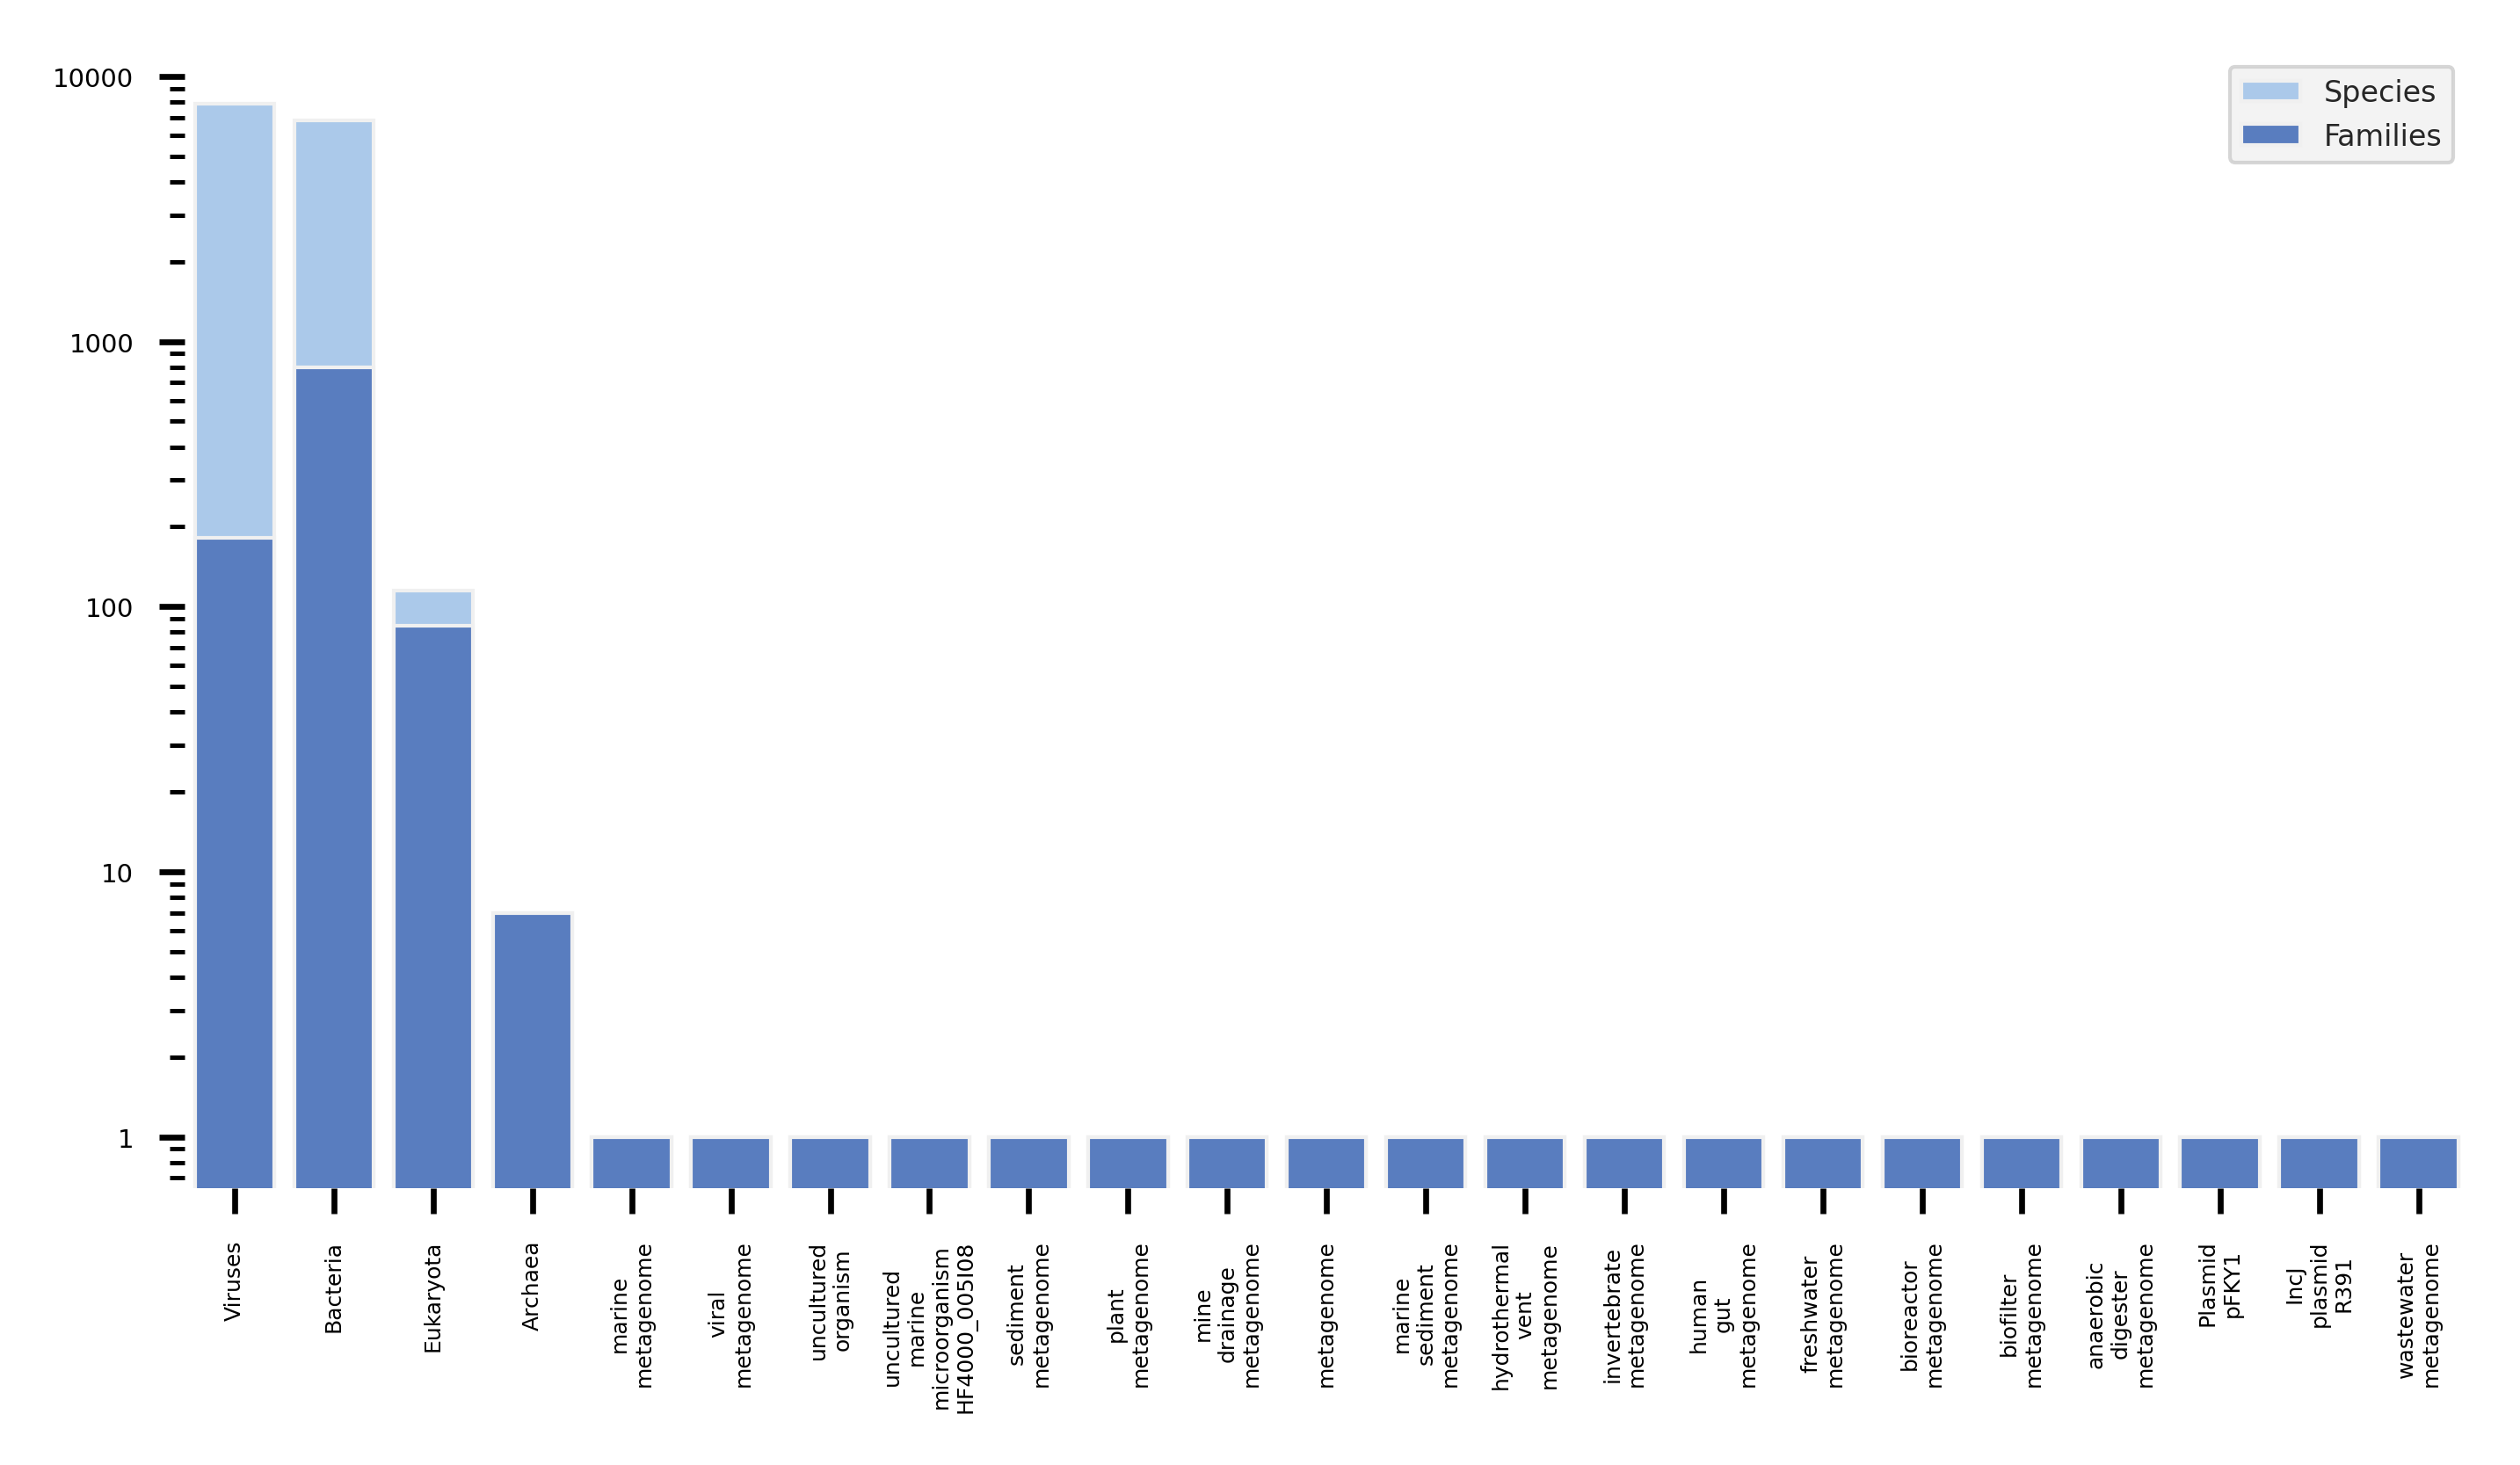

In [51]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(5, 3), dpi=600)
sns.set_theme(context="paper")
plt.style.use('fivethirtyeight')

sns.set_color_codes("pastel")
# ax.barh(
#     "Species superkingdom", "Species name",
#     data=overview.sort_values("Species name", ascending=True).reset_index().dropna(),
#     # labels, men_means, width, yerr=men_std, label='Men'
#     label="Species", color="b"
# )
sns.barplot(y="Species name", x="Species superkingdom",
            data=overview.sort_values("Species name", ascending=False).reset_index(),
            label="Species", color="b")

sns.set_color_codes("muted")
# ax.barh(
#     "Species superkingdom", "Species family",
#     data=overview.sort_values("Species name", ascending=True).reset_index(),
#     # labels, women_means, width, yerr=women_std, bottom=men_means, label='Women'
#     left="Species name", label="Families", color="r"
# )
sns.barplot(y="Species family", x="Species superkingdom",
            data=overview.sort_values("Species name", ascending=False).reset_index(),
            label="Families", color="b")

ax.legend(ncol=1, loc="upper right", frameon=True, fontsize=4)

ax.set(xlabel="", yscale="log", ylabel="")
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


# ax.set_title("Number of taxonomic species and family \nper pathogen superkingdom", fontdict=title_params)

# xticks = ax.get_xticks().tolist()
# xticks[7] = "uncultured marine\nmicroorganism HF4000_005I08"
# labels = [item.get_text() for item in ax.get_yticklabels()]
# labels[7] = "uncultured marine\nmicroorganism HF4000_005I08"
# for label in labels:
#     label = label.replace(" ", "\n")

# ax.set_xticks(ax.get_xticks())
# ax.set_yticks(ax.get_yticks())

ax.set_xticklabels(ax.get_xticklabels(), fontsize=3, rotation=90)
ax.set_yticklabels([int(tick) for tick in ax.get_yticks()], fontsize=3.5)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig("../assets/Superkingdom_family_species_bar.png")

<a id="filter"></a>

In [434]:
# Filter to include only viruses
df = df[df['Species superkingdom'] == 'Viruses']

In [435]:
df.sample(5)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Taxonomic lineage (SPECIES),Species name,Species superkingdom,Species family
8021,1959761,,Human stool-associated circular virus NG13,Capsid protein,Human associated circovirus 1,Human associated circovirus 1,Viruses,Circoviridae
2930,441976,,Asian leopard cat coronavirus Guangxi/F230/2006,Spike protein,Asian leopard cat coronavirus Guangxi/F230/2006,Asian leopard cat coronavirus Guangxi/F230/2006,Viruses,Coronaviridae
10602,2304510,,Culex Flavi-like virus,Core protein (EC 3.4.21.91) (EC 3.6.1.15) (EC ...,Culex Flavi-like virus,Culex Flavi-like virus,Viruses,Flaviviridae
11223,2502416,,Escherichia phage vB_EcoM_G53,Portal protein (gp20); Putative tail sheath pr...,Escherichia phage vB_EcoM_G53,Escherichia phage vB_EcoM_G53,Viruses,Myoviridae
9285,2041552,,Mycobacterium phage Terminus,Portal protein; Integrase,Mycobacterium phage Terminus,Mycobacterium phage Terminus,Viruses,Siphoviridae


In [436]:
df.drop(['Taxonomic lineage (SPECIES)'], axis=1, inplace=True)

In [437]:
# Convert empty strings to nan for easy downstream processing
df['Virus hosts'] = np.where(df['Virus hosts']=='', np.nan, df['Virus hosts'])

In [438]:
df[df['Virus hosts'].isnull()].sample(3)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Species name,Species superkingdom,Species family
7268,1891726,NaN,Merkel cell polyomavirus,Minor capsid protein VP2 (Minor structural pro...,Human polyomavirus 5,Viruses,Polyomaviridae
13112,2686099,NaN,Mycobacterium phage Phalm,Tyrosine integrase,Mycobacterium phage Phalm,Viruses,Siphoviridae
7264,1891720,NaN,Chlorocebus pygerythrus polyomavirus 3,Minor capsid protein; Capsid protein VP1,Chlorocebus pygerythrus polyomavirus 3,Viruses,Polyomaviridae


In [439]:
df.drop('Organism', axis=1, inplace=True) # Organism == Species name

In [440]:
dff.groupby("Species taxonomic ID").agg("count")

,Entry,Length
Species taxonomic ID,,
7.0,1,1
19.0,3,3
23.0,2,2
24.0,10,10
25.0,1,1
...,...,...
2846682.0,4,4
2846739.0,2,2
2881428.0,2,2


## Updating host names from other host data in the dataset

Premise: Same virus has same host irrespective of whether the info has been reviewed or not

In [441]:
# List of viruses which do not have assigned hosts in the data
noHostViruses = (df[df['Virus hosts'].isnull()]['Species name']
                 .unique()
                 .tolist())

In [442]:
# Create independent dataframe of viruses with no assigned host and simltaneously identify the same viruses from the data 
# whcih already have assigned hosts and assign host names based on those. 
df_na_hosts = df[(~df['Virus hosts'].isnull()) & (df['Species name'].isin(noHostViruses))][['Species name', 'Virus hosts']]
df_na_hosts = df_na_hosts.groupby('Species name')['Virus hosts'].apply(list) # Reduces dimention
df_na_hosts = df_na_hosts.reset_index(name='Viral hosts nw')

In [443]:
# Previous operation reurns a list for multiple host
# Converts the lists into regular string entries separated by a ;
df_na_hosts['Viral hosts nw'] = (df_na_hosts['Viral hosts nw']
                                 .swifter.progress_bar(desc='Joining host names list', enable=True)
                                 .apply('; '.join))

In [444]:
# Updates the viruses hosts info in the main dataset
df_naa = (df[df['Virus hosts'].isnull()]
          .merge(df_na_hosts, on='Species name', how='left')
          .drop('Virus hosts', axis=1)
          .rename({'Viral hosts nw':'Virus hosts'}, axis=1))

In [445]:
df_naa.shape

(7299, 6)

In [446]:
# Creates independant dataset with viruses which have hosts
df_notna = df[~df['Virus hosts'].isnull()]

In [447]:
df_notna.shape

(604, 6)

In [448]:
# merges the updated virus hosts dataset with the dataset with viruses which have hosts
df = df_naa.append(df_notna)

In [449]:
df.shape # Reduced dimention because of grouping, will later ungroup

(7903, 6)

In [450]:
df.sample(5)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
5053,2563550,Integrase,Pseudomonas phage vB_Pae_CF140a,Viruses,Siphoviridae,NaN
623,445517,Portal protein; Integrase,Staphylococcus phage tp310-3,Viruses,Siphoviridae,NaN
732,587370,Coat protein,Rudbeckia flower distortion virus,Viruses,Caulimoviridae,NaN
1940,1735562,Integrase,Roseobacter phage DSS3P8,Viruses,Siphoviridae,NaN
6409,2734123,Tail sheath monomer protein; Portal protein (g...,Synechococcus virus ACG2014bSyn7803C61,Viruses,Myoviridae,NaN


In [451]:
df[~df['Virus hosts'].isnull()].shape

(604, 6)

In [452]:
print(df[df['Virus hosts'].isnull()].shape)
df[df['Virus hosts'].isnull()].sample(3)

(7299, 6)


,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
3997,2303390,Capsid protein (Coat protein),Hollyhock yellow vein virus,Viruses,Geminiviridae,NaN
5638,2664405,Portal protein,Streptococcus phage phi-SsuSSJ27_rum,Viruses,Siphoviridae,NaN
2735,1971441,Portal protein,Streptococcus phage P8921,Viruses,Siphoviridae,NaN


In [453]:
df['Virus hosts'] = np.where(df['Virus hosts'].isnull(), '', df['Virus hosts'])

In [454]:
df.sample(3)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
1357,82676,Minor capsid protein L2; Major capsid protein L1,Omikronpapillomavirus 1,Viruses,Papillomaviridae,; Phocoena spinipinnis (Burmeister's porpoise)...
1137,1146877,Protease cofactor (pVI-C)]; Pre-protein VI (pV...,Bat mastadenovirus A,Viruses,Adenoviridae,
6790,2843755,Integrase,Bacillus virus BMBtp3,Viruses,Siphoviridae,


In [455]:
df = mergeRows(df, 'Species taxonomic ID','Virus hosts') # mergeRows in zoonosis_helper_functions.py

In [456]:
df[(df['Species name'].str.contains('Influenza A virus')) & (df['Virus hosts'] != '')]

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family
157,11320,; Aves [TaxID: 8782]; Phocidae (true seals) [T...,Nucleoprotein (Nucleocapsid protein) (Protein ...,Influenza A virus,Viruses,Orthomyxoviridae


In [457]:
df.sample(3)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family
7815,2846135,,Tail sheath protein; Portal protein (gp20),Salmonella virus moki,Viruses,Ackermannviridae
745,240426,,IMV surface protein (O3L); Conserved hypotheti...,Squirrelpox virus,Viruses,Poxviridae
7316,2767564,,Portal protein; Integrase,Mycobacterium phage Snekmaggedon,Viruses,Siphoviridae


In [458]:
# Separate dataset for easy tracking of updates
dfna = df[df['Virus hosts'] == '']
df = df[~(df['Virus hosts'] == '')]

In [459]:
track_na_size = dict()
track_na_size['Original'] = dfna.shape[0]
track_na_size.update({"Internal Update": dfna.shape[0]})
track_na_size

{'Original': 7299, 'Internal Update': 7299}

In [460]:
track_df_size = dict()
track_df_size['Original'] = df.shape[0]
track_df_size.update({"Internal Update": df.shape[0]})
track_df_size

{'Original': 604, 'Internal Update': 604}

## Updating host names from external sources

In [461]:
# Data from NCBI Virus
df2 = pd.read_csv('../data/sequences.csv')
df2.shape

(2599675, 3)

In [462]:
df2.sample(2)

,Species,Molecule_type,Host
2213175,Influenza A virus,ssRNA(-),Homo sapiens
2279169,Influenza A virus,ssRNA(-),Homo sapiens


In [463]:
df2.drop_duplicates(inplace=True)
df2.shape

(10956, 3)

In [464]:
# Get taxonomic IDs from species names
df2['Species ID'], df2['Host ID'] = df2['Species'].progress_apply(getIDfromName), df2['Host'].progress_apply(getIDfromName)

Getting Species name:   0%|          | 0/10956 [00:00<?, ?it/s]

'Bovine associated bovismacovirus 1'
'Human associated porprismacovirus 1'
'Torque teno seal virus 8'
'Bovine associated porprismacovirus 1'
'Sheep associated porprismacovirus 3'
'Sheep associated porprismacovirus 1'
'Sheep associated porprismacovirus 2'
'Bovine associated bovismacovirus 2'
'Bovine associated huchismacovirus 1'
'Bovine associated drosmacovirus 1'
'Bovine associated cosmacovirus 1'
'Bovine associated huchismacovirus 2'
'Torque teno seal virus 5'
'nan'
'nan'
'nan'
'nan'


Getting Species name:   0%|          | 0/10956 [00:00<?, ?it/s]

'Bolomys lasiurus'
'Bolomys lasiurus'
'Equus asinus x caballus'
'Pipistrellus sp. pipistrellus/pygmaeus AO-2021'
'Pipistrellus musciculus'
'Funisciurus bayonii'
'Rattus sp. r3 YH-2020'
'Rattus sp. r3 YH-2020'
'Soricidae sp. YH-2020'
'Rattus sp. r3 YH-2020'
'Rattus sp. r3 YH-2020'
'Acomys selousi'
'Rhinolophus smithersi'
'Alouatta sp.'
'Pipistrellys abramus'
'Sturnira angeli'
'Sturnira angeli'
'Hipposideros curtus'
'Pipistrellus inexspectatus'
'Dobsonia exoleta'
'Mops demonstrator'
'Pipistrellus musciculus'
'Mus sp. TG-2020'
'Murinae gen. sp. TG-2020'
'Vespadelus baverstocki'
'Ozimops sp. DP-2019'
'Scoterepens balstoni'
'Neoromicia capensis'
'Neoromicia capensis'
'Mus sp. CL-2019'
'Mus sp. CL-2019'
'Neoromicia capensis'
'Equus asinus x caballus'
'Equus caballus x asinus'
'Bolomys lasiurus'
'Bolomys lasiurus'
'Bolomys lasiurus'
'Neoromicia capensis'
'Neoromicia capensis'
'Neoromicia capensis'
'Neoromicia capensis'
'Bolomys lasiurus'
'Pipistrellus inexspectatus'
'Chiroptera sp.'
'Chaereph

In [465]:
df2.dropna(inplace=True)
df2['Species ID'], df2['Host ID'] = df2['Species ID'].astype(int), df2['Host ID'].astype(int)
df2.shape

(10866, 5)

In [466]:
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['Host'], x['Host ID']), axis=1)
# Remove Host and Host ID columns as they have been merged and are no longer needed
df2.drop(['Host', 'Host ID'], axis=1, inplace=True)

Getting Species name:   0%|          | 0/10866 [00:00<?, ?it/s]

In [467]:
df2['Species ID'] = df2['Species ID'].progress_apply(getRankID, rank='species')

Getting Species name:   0%|          | 0/10866 [00:00<?, ?it/s]

In [468]:
## Create a copy for later use
dfff = df2.copy()

In [469]:
# Add host names
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [470]:
dfna.shape

(6271, 6)

In [471]:
df.shape

(1632, 6)

In [472]:
track_na_size.update({"NCBI virus Update": dfna.shape[0]})

track_df_size.update({"NCBI virus Update": df.shape[0]})
track_df_size

{'Original': 604, 'Internal Update': 604, 'NCBI virus Update': 1632}

In [473]:
# Data from virus host database
df2 = pd.read_table('../data/virushostdb.tsv')
df2.head(3)

,virus tax id,virus name,virus lineage,refseq id,KEGG GENOME,KEGG DISEASE,DISEASE,host tax id,host name,host lineage,pmid,evidence,sample type,source organism
0,438782,Abaca bunchy top virus,Viruses; Monodnaviria; Shotokuvirae; Cressdnav...,"NC_010314, NC_010315, NC_010316, NC_010317, NC...",NaN,NaN,NaN,46838.0,Musa sp.,Eukaryota; Viridiplantae; Streptophyta; Strept...,17978886,"Literature, NCBI Virus, RefSeq",NaN,NaN
1,438782,Abaca bunchy top virus,Viruses; Monodnaviria; Shotokuvirae; Cressdnav...,"NC_010314, NC_010315, NC_010316, NC_010317, NC...",NaN,NaN,NaN,214697.0,Musa acuminata AAA Group,Eukaryota; Viridiplantae; Streptophyta; Strept...,17978886,Literature,NaN,NaN
2,1241371,Abalone herpesvirus Victoria/AUS/2009,Viruses; Duplodnaviria; Heunggongvirae; Peplov...,NC_018874,NaN,NaN,NaN,6451.0,Haliotidae,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,NaN,UniProt,NaN,NaN


In [474]:
df2 = df2[['virus tax id', 'virus name', 'host tax id', 'host name']].copy()
df2.drop_duplicates(inplace=True)
print(df2.shape)
df2.head()

(16612, 4)


,virus tax id,virus name,host tax id,host name
0,438782,Abaca bunchy top virus,46838.0,Musa sp.
1,438782,Abaca bunchy top virus,214697.0,Musa acuminata AAA Group
2,1241371,Abalone herpesvirus Victoria/AUS/2009,6451.0,Haliotidae
3,1241371,Abalone herpesvirus Victoria/AUS/2009,36100.0,Haliotis rubra
4,491893,Abalone shriveling syndrome-associated virus,37770.0,Haliotis diversicolor aquatilis


In [475]:
df2[df2['host tax id'].isnull()]

,virus tax id,virus name,host tax id,host name
1236,2662138,Bacteriophage Phobos,NaN,NaN
3750,1131416,Cucurbit mild mosaic virus,NaN,NaN
15925,1888308,Wabat virus,NaN,NaN


In [476]:
df2.dropna(inplace=True)

In [477]:
df2['host tax id'] = df2['host tax id'].astype(int)
df2.head()

,virus tax id,virus name,host tax id,host name
0,438782,Abaca bunchy top virus,46838,Musa sp.
1,438782,Abaca bunchy top virus,214697,Musa acuminata AAA Group
2,1241371,Abalone herpesvirus Victoria/AUS/2009,6451,Haliotidae
3,1241371,Abalone herpesvirus Victoria/AUS/2009,36100,Haliotis rubra
4,491893,Abalone shriveling syndrome-associated virus,37770,Haliotis diversicolor aquatilis


In [478]:
df2['Species ID'] = df2['virus tax id'].progress_apply(getRankID, rank='species')

Getting Species name:   0%|          | 0/16609 [00:00<?, ?it/s]

In [479]:
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['host name'], x['host tax id']), axis=1)
# Remove Host and Host ID columns as they have been merged and are no longer needed
df2.drop(['host name', 'host tax id'], axis=1, inplace=True)
df2.head()

Getting Species name:   0%|          | 0/16609 [00:00<?, ?it/s]

,virus tax id,virus name,Species ID,Host name
0,438782,Abaca bunchy top virus,438782,Musa sp. [TaxID: 46838]
1,438782,Abaca bunchy top virus,438782,Musa acuminata AAA Group [TaxID: 214697]
2,1241371,Abalone herpesvirus Victoria/AUS/2009,1513231,Haliotidae [TaxID: 6451]
3,1241371,Abalone herpesvirus Victoria/AUS/2009,1513231,Haliotis rubra [TaxID: 36100]
4,491893,Abalone shriveling syndrome-associated virus,491893,Haliotis diversicolor aquatilis [TaxID: 37770]


In [480]:
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [481]:
df.shape

(4731, 6)

In [482]:
dfna.shape

(3172, 6)

In [483]:
track_na_size.update({"Virus-Host DB Update": dfna.shape[0]})

track_df_size.update({"Virus-Host DB Update": df.shape[0]})
track_df_size

{'Original': 604,
 'Internal Update': 604,
 'NCBI virus Update': 1632,
 'Virus-Host DB Update': 4731}

In [484]:
# Data from EID2 (Liverpool University)
df2 = pd.read_csv('../data/virus_host_4rm_untitled.csv')
df2.sample(2)

,Host_name,Host_TaxId,Host Group,Virus_name,Virus_TaxId,Micobe_group,Host_common_name,Host_common_name_rev
21943,homo sapiens,9606,primates,influenza a virus (a/hunan-beihu/1313/2009(h3n2)),750848,viruses,Human,Human
41938,homo sapiens,9606,primates,influenza a virus (a/new york/601/1996(h3n2)),370521,viruses,Human,Human


In [485]:
df2 = df2[['Host_name', 'Host_TaxId', 'Virus_name', 'Virus_TaxId']].copy()
df2['Species ID'] = df2['Virus_TaxId'].progress_apply(getRankID, rank='species')
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['Host_name'], x['Host_TaxId']), axis=1)
df2.drop(['Host_name', 'Host_TaxId'], axis=1, inplace=True)
df2.dropna(inplace=True)
df2.sample(2)

Getting Species name:   0%|          | 0/59859 [00:00<?, ?it/s]

878474 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found


Getting Species name:   0%|          | 0/59859 [00:00<?, ?it/s]

,Virus_name,Virus_TaxId,Species ID,Host name
52069,influenza a virus (a/mallard/interior alaska/7...,593176,11320.0,anas platyrhynchos [TaxID: 8839]
3292,bovine viral diarrhea virus 1,11099,2170080.0,odocoileus hemionus [TaxID: 9872]


In [486]:
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [487]:
df.shape

(4737, 6)

In [488]:
dfna.shape

(3166, 6)

In [489]:
dfna.sample(2)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
2000,2560380,Capsid protein (Coat protein),Chilli leaf curl Gonda virus,Viruses,Geminiviridae,NaN
1723,2530120,Portal protein; Integrase,Mycobacterium phage Bobby,Viruses,Siphoviridae,NaN


In [490]:
track_na_size.update({"EID2 Update": dfna.shape[0]})

track_df_size.update({"EID2 Update": df.shape[0]})
track_df_size

{'Original': 604,
 'Internal Update': 604,
 'NCBI virus Update': 1632,
 'Virus-Host DB Update': 4731,
 'EID2 Update': 4737}

In [491]:
track_na_size

{'Original': 7299,
 'Internal Update': 7299,
 'NCBI virus Update': 6271,
 'Virus-Host DB Update': 3172,
 'EID2 Update': 3166}

In [492]:
tick_labels = "Original", "Internal Update", "NCBI virus\nUpdate", "Virus-Host DB\nUpdate", "EID2 Update"

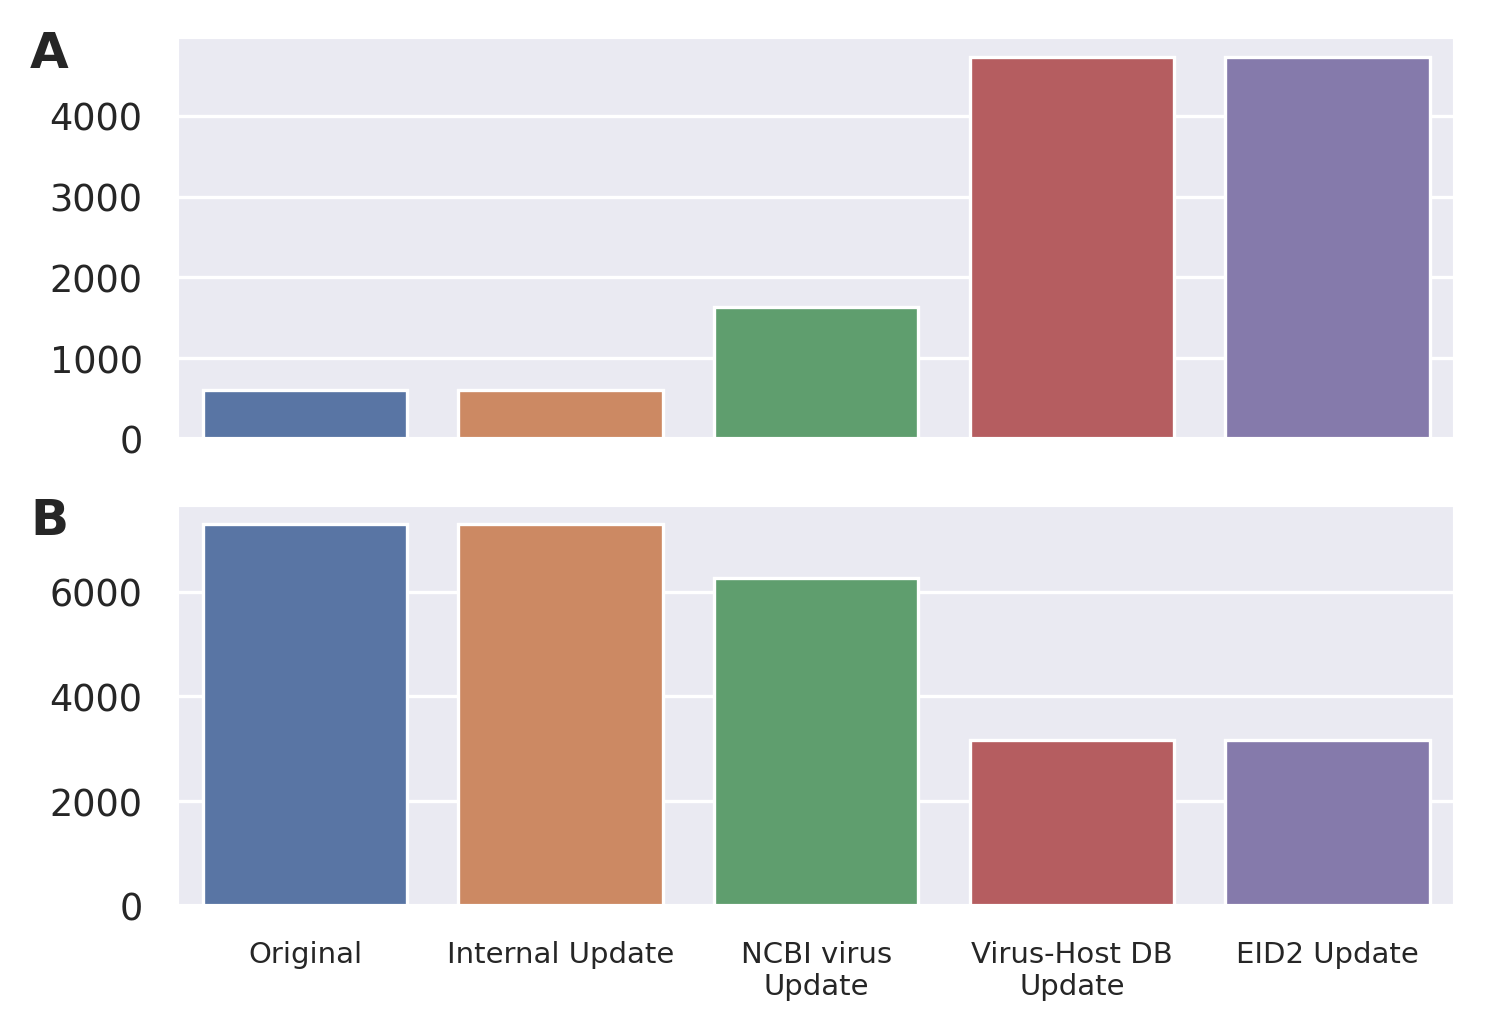

In [493]:
# fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 3.5), dpi=300)

# # fig.suptitle('Dataset tracking through imputation cycle', fontsize=17, fontweight="bold")

# sns.set_theme(context="paper", style="fivethirtyeight")

# sns.barplot(data=pd.DataFrame().from_records([track_df_size]), ax=ax[0])

# sns.barplot(data=pd.DataFrame().from_records([track_na_size]), ax=ax[1])
# ax[1].set_xticklabels(tick_labels, fontsize=7)
# ax[0].set_ylabel("A", fontsize=12, fontweight='bold', rotation=0)
# ax[0].yaxis.set_label_coords(-.1, .9)
# ax[1].set_ylabel("B", fontsize=12, fontweight='bold', rotation=0)
# ax[1].yaxis.set_label_coords(-.1, .9)

# # ax[1].set(axes='x', rotate=45)

# # ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=15)

# plt.tight_layout()
# plt.savefig("../assets/Tracking.png")

## Further Processing

In [494]:
# Add column to discriminate viruses which contain human hosts from those which do not
df['Infects human'] = np.where(df['Virus hosts'].str.contains(r'960[56]'), 'human-true','human-false')

In [495]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
261,35258,Canis lupus familiaris (Dog) (Canis familiaris...,Minor capsid protein L2; Major capsid protein L1,Lambdapapillomavirus 2,Viruses,Papillomaviridae,human-false
3209,2301566,Mycobacterium [TaxID: 1763],Integrase,Mycobacterium phage JoeyJr,Viruses,Siphoviridae,human-false


In [496]:
df['Virus hosts'] = df['Virus hosts'].str.split('; ')
df['Virus hosts'] = df.progress_apply(lambda x: list(filter(None, x['Virus hosts'])), axis=1) # remove empty items
df['Virus hosts'] = df['Virus hosts'].progress_apply('; '.join)

Getting Species name:   0%|          | 0/4737 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/4737 [00:00<?, ?it/s]

In [497]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
413,70796,Phasianidae (turkeys) [TaxID: 9005]; Anas (duc...,Genome polyprotein (EC 2.7.7.48) (P1C) (P1D) (...,Tremovirus A,Viruses,Picornaviridae,human-false
3806,2733359,Pseudomonas aeruginosa PAO1 [TaxID: 208964],Head-tail connector protein,Pseudomonas virus PAXYB1,Viruses,Autographiviridae,human-false
3398,2560382,Nicotiana benthamiana [TaxID: 4100],Envelopment polyprotein (Glycoprotein C) (Glyc...,Chrysanthemum stem necrosis orthotospovirus,Viruses,Tospoviridae,human-false
3837,2733587,Salmonella enterica subsp. enterica serovar Ty...,Head portal protein,Escherichia virus UAB78,Viruses,Autographiviridae,human-false


In [498]:
df[df['Infects human'] == 'human-true'].sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
371,63330,Equus caballus (Horse) [TaxID: 9796]; Pteropus...,Attachment glycoprotein; Glycoprotein G; Fusio...,Hendra henipavirus,Viruses,Paramyxoviridae,human-true
2011,1618189,Homo sapiens [TaxID: 9606],Nucleoprotein,Bourbon virus,Viruses,Orthomyxoviridae,human-true
591,194440,Homo sapiens (Human) [TaxID: 9606],Transmembrane protein (TM) (Glycoprotein 21) (...,Primate T-lymphotropic virus 1,Viruses,Retroviridae,human-true
2252,1891764,Homo sapiens (Human) [TaxID: 9606],Major capsid protein VP1 (Major structural pro...,Human polyomavirus 3,Viruses,Polyomaviridae,human-true


<a id="host-name-consistency"></a>

In [499]:
# Ungrouping operation based on host
# 1. Splits Virus host using based on ; separator
# 2. Horizontally stack the data based on virus hosts
df = (df.set_index(df.columns.drop('Virus hosts', 1).tolist())['Virus hosts'].str.split(';', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Virus hosts'})
          .loc[:, df.columns]
         ).copy()

In [500]:
df.shape

(7247, 7)

In [501]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
3356,1508220,Rhinolophus ferrumequinum [TaxID: 59479],Spike protein; S protein; Spike glycoprotein,Bat coronavirus,Viruses,Coronaviridae,human-false
6562,2734160,Burkholderia [TaxID: 32008],Uncharacterized protein; Putative tail fiber p...,Burkholderia virus KL4,Viruses,Podoviridae,human-false
6126,2732026,Salmonella enterica subsp. enterica serovar Ty...,Portal (Connector) protein,Salmonella virus S116,Viruses,Demerecviridae,human-false
1568,270146,Acalypha indica [TaxID: 478095],Capsid protein (Coat protein),Tomato leaf curl Sudan virus,Viruses,Geminiviridae,human-false


In [502]:
df['Virus hosts ID'] = None
idx_organism = df.columns.get_loc('Virus hosts')
idx_host_id = df.columns.get_loc('Virus hosts ID')

pattern = r'(\d+)\]' # The last digit on some IDs was not captured so include the ] to capture & later remove
for row in range(len(df)):
    host_id = re.search(pattern, df.iat[row, idx_organism]).group()
    df.iat[row, idx_host_id] = host_id
df.head()

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID
0,10243,Bos taurus (Bovine) [TaxID: 9913],Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,9913]
1,10243,Mus musculus (Mouse) [TaxID: 10090],Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,10090]
2,10243,Felis catus (Cat) (Felis silvestris catus) [T...,Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,9685]
3,10243,Loxodonta africana (African elephant) [TaxID:...,Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,9785]
4,10243,Myodes glareolus (Bank vole) (Clethrionomys g...,Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,447135]


In [503]:
df['Virus hosts ID'] = df['Virus hosts ID'].str.strip('\]')

In [504]:
df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(int)

df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(getRankID, rank='species')
df['Virus host name'] = df['Virus hosts ID'].progress_apply(getRankName, rank='species')
df['Host superkingdom'] = df['Virus hosts ID'].progress_apply(getRankName, rank='superkingdom')
df['Host kingdom'] = df['Virus hosts ID'].progress_apply(getRankName, rank='kingdom')

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

In [505]:
df[df['Virus hosts ID'].isna()]

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom


In [506]:
df['Virus hosts ID'][1866]

229543

In [507]:
df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(int)

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

In [508]:
df['Virus hosts'] = (df.drop('Virus hosts', axis=1)
                     .apply(lambda x: nameMerger(x['Virus host name'], x['Virus hosts ID']), axis=1))

In [509]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
4204,1920777,Klebsiella pneumoniae [TaxID: 573],Head-tail connector protein,Klebsiella virus KP34,Viruses,Autographiviridae,human-false,573,Klebsiella pneumoniae,Bacteria,Klebsiella pneumoniae
7143,2846106,Salmonella enterica [TaxID: 28901],Portal protein (gp20); Uncharacterized protein,Salmonella virus SP1,Viruses,Ackermannviridae,human-false,28901,Salmonella enterica,Bacteria,Salmonella enterica
4587,1980915,Paralichthys olivaceus [TaxID: 8255],Glycoprotein,Hirame novirhabdovirus,Viruses,Rhabdoviridae,human-false,8255,Paralichthys olivaceus,Eukaryota,Metazoa
3016,1329380,Oxalis corniculata [TaxID: 212256],Capsid protein (Coat protein),Ageratum Yellow vein China virus - OX1,Viruses,Geminiviridae,human-false,212256,Oxalis corniculata,Eukaryota,Viridiplantae


In [510]:
df.shape

(7247, 11)

In [511]:
# Ungroup based on protein names
df = (df.set_index(df.columns.drop('Protein names',1).tolist())['Protein names']
          .str.split(';', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Protein names'})
          .loc[:, df.columns]
         ).copy()

In [512]:
df.shape

(22528, 11)

In [513]:
df[df["Species name"] == "Vaccinia virus"]["Virus hosts"].unique()

array(['Bos taurus [TaxID: 9913]', 'Homo sapiens [TaxID: 9606]',
       'Equus caballus [TaxID: 9796]',
       'Oryctolagus cuniculus [TaxID: 9986]'], dtype=object)

In [514]:
df[df['Host superkingdom'].isnull()].shape

(0, 11)

In [515]:
df['Host superkingdom'].unique()

array(['Eukaryota', 'Bacteria', 'Viruses', 'root', 'Archaea'],
      dtype=object)

In [516]:
df[df['Host superkingdom'] == 'Eukaryota'].shape

(18356, 11)

In [517]:
df[df['Host superkingdom'] == 'Viruses'].shape

(4, 11)

In [518]:
df[df['Host superkingdom'] == 'Bacteria'].shape

(4116, 11)

In [519]:
df[df['Host superkingdom'] == 'root'].shape

(38, 11)

In [520]:
df[df['Host superkingdom'] == 'Archaea'].shape

(14, 11)

In [521]:
print(df[df['Host kingdom'] == 'Metazoa'].shape)
df[df['Host kingdom'] == 'Metazoa'].sample(3)

(17292, 11)


,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
830,10245,Equus caballus [TaxID: 9796],HSPV101,Vaccinia virus,Viruses,Poxviridae,human-true,9796,Equus caballus,Eukaryota,Metazoa
7513,47929,Macaca mulatta [TaxID: 9544],Envelope glycoprotein H (gH),Macacine betaherpesvirus 3,Viruses,Herpesviridae,human-false,9544,Macaca mulatta,Eukaryota,Metazoa
14452,1511084,Bubalus bubalis [TaxID: 89462],NP,Influenza D virus,Viruses,Orthomyxoviridae,human-false,89462,Bubalus bubalis,Eukaryota,Metazoa


In [522]:
df[df['Infects human'] == 'human-true'].shape

(8442, 11)

In [523]:
df[df['Infects human'] == 'human-false'].shape

(14086, 11)

In [524]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
20948,2733368,Aeromonas hydrophila [TaxID: 644],Putative head portal protein,Aeromonas virus Ahp1,Viruses,Autographiviridae,human-false,644,Aeromonas hydrophila,Bacteria,Aeromonas hydrophila
14801,1511906,Neogale vison [TaxID: 452646],Capsid protein 2 (Structural protein 2),Carnivore protoparvovirus 1,Viruses,Parvoviridae,human-false,452646,Neogale vison,Eukaryota,Metazoa


In [525]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
2603,11072,Culex tritaeniorhynchus [TaxID: 7178],Non-structural protein 1' (NS1')],Japanese encephalitis virus,Viruses,Flaviviridae,human-true,7178,Culex tritaeniorhynchus,Eukaryota,Metazoa
15075,1541887,Salmonella [TaxID: 590],Portal protein,Salmonella virus Chi,Viruses,Siphoviridae,human-false,590,Salmonella,Bacteria,Salmonella


<a id="issue"></a>

In [526]:
## Virus host name != Virus hosts ### Shared names but not ID eg. Influenza A strain 4 & Influenza A strain 4 == same ID but diff name
for column in df.columns:
    print(column, df[column].nunique())
print('\nDataframe total',len(df))

Species taxonomic ID 4737
Virus hosts 1765
Protein names 2063
Species name 4737
Species superkingdom 1
Species family 85
Infects human 2
Virus hosts ID 1765
Virus host name 1756
Host superkingdom 5
Host kingdom 345

Dataframe total 22528


In [527]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
16403,1912147,Pteropus giganteus [TaxID: 143291],Capsid protein VP34,Mamastrovirus sp.,Viruses,Astroviridae,human-true,143291,Pteropus giganteus,Eukaryota,Metazoa
16733,1913686,Escherichia coli [TaxID: 562],Long tail fiber protein p37 (Receptor-recogni...,Escherichia virus VR26,Viruses,Myoviridae,human-false,562,Escherichia coli,Bacteria,Escherichia coli


## Restructuring the data

In [528]:
# Earlier saved data
dff.sample(2)

,Entry,Species taxonomic ID,Length
352029,A0A014DRY5,1310906.0,441
310580,A0A385GMQ2,11676.0,862


In [529]:
dff.shape

(358333, 3)

In [530]:
## Load sequences
# Using custom IO instead of Bio.SeqIO because it was much easier to customise
# Not as efficient but still light on resources

<a id='fasta'></a>

In [531]:
%%time

fastaFileName = '../data/uniprot-keyword Virus+entry+into+host+cell+[KW-1160] +fragment no.fasta'

entry_seq = read_fasta(fastaFileName) # read_fasta in zoonosis_helper_functions.py

CPU times: user 3.21 s, sys: 862 ms, total: 4.07 s
Wall time: 4.06 s


In [532]:
dff.sort_values(by='Entry', inplace=True)

seq_object_list = [seq_obj for entry, seq_obj in entry_seq]

dff['Sequence'] = seq_object_list

In [533]:
dff.head()

,Entry,Species taxonomic ID,Length,Sequence
50368,A0A009FEK4,470.0,392,<zoonosis_helper_functions.FASTASeq object at ...
156673,A0A009G3H3,1310609.0,385,<zoonosis_helper_functions.FASTASeq object at ...
146717,A0A009GC36,470.0,400,<zoonosis_helper_functions.FASTASeq object at ...
146730,A0A009GCG0,470.0,410,<zoonosis_helper_functions.FASTASeq object at ...
144753,A0A009GXT7,1310609.0,399,<zoonosis_helper_functions.FASTASeq object at ...


In [534]:
df.drop(['Virus host name', 'Protein names', 'Species superkingdom'], axis=1, inplace=True)

In [535]:
%%time

df = df.merge(dff, on='Species taxonomic ID', how='left')

df.shape

CPU times: user 12.7 s, sys: 7.45 s, total: 20.1 s
Wall time: 20.1 s


(48729124, 11)

In [536]:
del dff, df2

In [537]:
%%time

df.drop_duplicates(inplace=True)
df.shape

CPU times: user 41.4 s, sys: 15 s, total: 56.4 s
Wall time: 56.2 s


(2277906, 11)

In [538]:
df['Virus hosts ID'] = df['Virus hosts ID'].apply(str)

In [539]:
df.head()

,Species taxonomic ID,Virus hosts,Species name,Species family,Infects human,Virus hosts ID,Host superkingdom,Host kingdom,Entry,Length,Sequence
0,10243,Bos taurus [TaxID: 9913],Cowpox virus,Poxviridae,human-true,9913,Eukaryota,Metazoa,A0A0K2YUN2,340.0,<zoonosis_helper_functions.FASTASeq object at ...
1,10243,Bos taurus [TaxID: 9913],Cowpox virus,Poxviridae,human-true,9913,Eukaryota,Metazoa,A0A1B5FLS7,377.0,<zoonosis_helper_functions.FASTASeq object at ...
2,10243,Bos taurus [TaxID: 9913],Cowpox virus,Poxviridae,human-true,9913,Eukaryota,Metazoa,A0A1S5WL42,304.0,<zoonosis_helper_functions.FASTASeq object at ...
3,10243,Bos taurus [TaxID: 9913],Cowpox virus,Poxviridae,human-true,9913,Eukaryota,Metazoa,A0A1V0FXA9,304.0,<zoonosis_helper_functions.FASTASeq object at ...
4,10243,Bos taurus [TaxID: 9913],Cowpox virus,Poxviridae,human-true,9913,Eukaryota,Metazoa,A0A1V0FXG9,377.0,<zoonosis_helper_functions.FASTASeq object at ...


In [540]:
%%time

# Group by Entry and aggregate using set function to avoid duplication
df = (df.groupby('Entry', as_index=False)
       .agg({'Virus hosts':set, #'Protein':set, 
             'Infects human':set, 'Species name':set,
             'Host superkingdom':set,
             'Host kingdom':set,
             'Virus hosts ID':set,
             'Species family':set,
             'Species taxonomic ID':'first',
             'Sequence': 'first', 'Length': 'first',})) 

# joint the set columns into a string separated by a ;
# First column is 'Entry' so skip index 0, last 3 columns need not be joined
df.iloc[:, 1:-3] = df.iloc[:, 1:-3].swifter.applymap('; '.join)

Pandas Apply:   0%|          | 0/2222927 [00:00<?, ?it/s]

CPU times: user 18.4 s, sys: 958 ms, total: 19.4 s
Wall time: 19.4 s


In [541]:
df.shape

(317561, 11)

In [542]:
%%time

# Get additional sequence info from the dataset
df['Sequence'] = df.progress_apply(lambda x: getSequenceFeatures(
    seqObj=x['Sequence'], entry=x['Entry'],
    organism=x['Species name'], status=x['Infects human']), axis=1)

Pandas Apply:   0%|          | 0/317561 [00:00<?, ?it/s]

CPU times: user 6.8 s, sys: 120 ms, total: 6.92 s
Wall time: 6.89 s


<a id="protein-names-from-sequence"></a>

In [543]:
df['Protein'] = df['Sequence'].apply(lambda sequence: sequence.protein_name)

In [544]:
df.sample(3)

,Entry,Virus hosts,Infects human,Species name,Host superkingdom,Host kingdom,Virus hosts ID,Species family,Species taxonomic ID,Sequence,Length,Protein
165366,A0A6G5NHS1,Homo sapiens [TaxID: 9606],human-true,Human immunodeficiency virus 1,Eukaryota,Metazoa,9606,Retroviridae,11676,<zoonosis_helper_functions.FASTASeq object at ...,858.0,Envelope glycoprotein gp160
200743,C3TUM6,Sus scrofa [TaxID: 9823]; Macaca mulatta [TaxI...,human-true,Rotavirus A,Eukaryota,Metazoa,10090; 9612; 9913; 9823; 9544; 9606; 9986; 979...,Reoviridae,28875,<zoonosis_helper_functions.FASTASeq object at ...,775.0,Outer capsid protein VP4
140088,A0A3S7RP71,Mustela lutreola [TaxID: 9666]; Sus scrofa [Ta...,human-true,Influenza A virus,Eukaryota,Metazoa,9685; 9031; 8782; 9666; 9823; 9694; 9709; 2766...,Orthomyxoviridae,11320,<zoonosis_helper_functions.FASTASeq object at ...,569.0,Hemagglutinin


In [545]:
df[df['Infects human'] == 'human-true'].shape

(278791, 12)

In [546]:
df[df['Infects human'] == 'human-false'].shape

(38770, 12)

In [547]:
# Sequences loaded earlier from NCBI Virus ###Add Molecule type
dfff.rename({'Species ID': 'Species taxonomic ID', 'Molecule_type': 'Molecule type'}, axis=1, inplace=True)
dfff.head()

,Species,Molecule type,Species taxonomic ID,Host name
0,Epsilonarterivirus zamalb,ssRNA(+),2501966,Chlorocebus [TaxID: 392815]
1,Rodent arterivirus,ssRNA(+),1806636,Eothenomys inez [TaxID: 870526]
2,Wencheng Sm shrew coronavirus,ssRNA(+),1508228,Suncus murinus [TaxID: 9378]
3,Bat coronavirus,ssRNA(+),1508220,Eidolon helvum [TaxID: 77214]
4,NL63-related bat coronavirus strain BtKYNL63-9b,ssRNA(+),2501929,Triaenops afer [TaxID: 549403]


In [548]:
df['Species taxonomic ID'] = df['Species taxonomic ID'].apply(int)

In [549]:
%%time

df = df.merge(dfff[['Species taxonomic ID', 'Molecule type']], how='left', on='Species taxonomic ID')

CPU times: user 3.3 s, sys: 1.73 s, total: 5.03 s
Wall time: 5.02 s


In [550]:
df.shape

(8419758, 13)

In [551]:
%%time

df.drop_duplicates(inplace=True)

CPU times: user 10 s, sys: 2.75 s, total: 12.8 s
Wall time: 12.8 s


In [552]:
df.shape

(317561, 13)

In [553]:
del dfff

## Reorganise dataframe

In [554]:
df = df[['Entry', 'Protein', 'Length', 'Species name', 
         'Species taxonomic ID', 'Species family', 'Virus hosts',
         'Virus hosts ID', 'Host kingdom', 
         'Host superkingdom', 'Molecule type', 'Infects human', 'Sequence']]

In [555]:
df.sample(2)

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence
1629970,A0A172SJG4,Hemagglutinin,585.0,Influenza B virus,11520,Orthomyxoviridae,Homo sapiens [TaxID: 9606],9606,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...
4745400,A6M7J0,Hemagglutinin,566.0,Influenza A virus,11320,Orthomyxoviridae,Mustela lutreola [TaxID: 9666]; Sus scrofa [Ta...,9685; 9031; 8782; 9666; 9823; 9694; 9709; 2766...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...


## Select data for proof of concept

In [556]:
selection = {
    "Bat coronavirus": "Spike glycoprotein", # 1395
    "Human coronavirus 229E": "Spike glycoprotein", # 1582
    "Human immunodeficiency virus 1": "Envelope glycoprotein gp160", # 929
    "Influenza D virus":"Nucleoprotein" # 552
    }

In [557]:
def get_proof_of_concept_entries(df, virus, protein):
    citerion = (df["Species name"].str.contains(virus) & df["Protein"].str.contains(protein))
    max_len = df[citerion]["Length"].max()
    result = df[citerion & (df["Length"] == max_len)].iloc[0:1,:].copy()
    return result

In [558]:
get_proof_of_concept_entries(df, "Bat coronavirus", "Spike glycoprotein")

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence
2539916,A0A1W5YKT3,Spike glycoprotein,1395.0,Bat coronavirus,1508220,Coronaviridae,Hipposideros cineraceus [TaxID: 270698]; Myoti...,242383; 77214; 452653; 9408; 498220; 258959; 1...,Metazoa,Eukaryota,ssRNA(+),human-false,<zoonosis_helper_functions.FASTASeq object at ...


In [559]:
poc_df = pd.DataFrame()

for virus, protein in selection.items():
    poc_df = pd.concat([poc_df, get_proof_of_concept_entries(df, virus, protein)])

poc_df.index

Int64Index([2539916, 1190787, 7585933, 1047167], dtype='int64')

In [560]:
df.shape

(317561, 13)

In [561]:
df.drop(poc_df.index, axis=0, inplace=True)

In [562]:
df.shape

(317557, 13)

In [563]:
folder = "/scratch2/users/rserage/Proof_of_Concept"
# dff = dt
# file = 'Proof_of_Concept'
os.makedirs(folder, exist_ok=True)

# save dataframe as csv
poc_df.drop('Sequence', axis=1).to_csv(f'{folder}/proof_of_concept_data.csv', index=False)
save_sequences(poc_df, f'{folder}/Sequences')

## Split Dataframe to multiple datasets

In [564]:
df['Host superkingdom'].unique()

array(['Eukaryota', 'Bacteria', 'root', 'Archaea', 'Viruses',
       'root; Eukaryota'], dtype=object)

In [565]:
df['Host kingdom'].unique()

array(['Metazoa', 'Viridiplantae', 'Lactococcus lactis',
       'Escherichia coli', 'Serratia marcescens',
       'Mycolicibacterium smegmatis', 'Bacillus thuringiensis',
       'Trichormus variabilis', 'Listeria monocytogenes',
       'Pseudomonas syringae', 'Viridiplantae; Metazoa',
       'Cronobacter sakazakii', 'Staphylococcus epidermidis',
       'Enterococcus faecium', 'root', 'Caulobacter vibrioides',
       'Vibrio alginolyticus', 'Staphylococcus aureus', 'Bacillus cereus',
       'Ralstonia solanacearum', 'Klebsiella pneumoniae',
       'Staphylococcus xylosus; Staphylococcus aureus',
       'Acinetobacter baumannii', 'Dickeya sp.',
       'Lactobacillus delbrueckii', 'Salmonella', 'Bacillus pumilus',
       'Citrobacter freundii; Citrobacter', 'Mycobacterium',
       'Rhizobium leguminosarum', 'Mesorhizobium loti',
       'Shigella flexneri', 'Yersinia enterocolitica',
       'Idiomarinaceae bacterium N2-2', 'Sulfitobacter sp. CB2047',
       'Lelliottia sp. GL2', 'Clostridi

In [566]:
df[(df['Host kingdom'].str.contains('Viridiplantae')) | df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens')].shape

(284537, 13)

In [567]:
df.columns

Index(['Entry', 'Protein', 'Length', 'Species name', 'Species taxonomic ID',
       'Species family', 'Virus hosts', 'Virus hosts ID', 'Host kingdom',
       'Host superkingdom', 'Molecule type', 'Infects human', 'Sequence'],
      dtype='object')

In [568]:
df.shape

(317557, 13)

In [569]:
df['Molecule type'] = np.where(df['Molecule type'] == "", np.nan, df['Molecule type'])

In [570]:
df['Molecule type'] = np.where(df['Molecule type'] == "unknown", np.nan, df['Molecule type'])

In [571]:
df

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence
0,A0A023H4K0,Core protein,3391.0,Dengue virus,12637,Flaviviridae,Diceromyia [TaxID: 53539]; Aedes polynesiensis...,299627; 7159; 9538; 7160; 53540; 188700; 29962...,Metazoa,Eukaryota,ssRNA(+),human-true,<zoonosis_helper_functions.FASTASeq object at ...
15,A0A023H4L2,Core protein,3391.0,Dengue virus,12637,Flaviviridae,Diceromyia [TaxID: 53539]; Aedes polynesiensis...,299627; 7159; 9538; 7160; 53540; 188700; 29962...,Metazoa,Eukaryota,ssRNA(+),human-true,<zoonosis_helper_functions.FASTASeq object at ...
30,A0A023H573,Core protein,3391.0,Dengue virus,12637,Flaviviridae,Diceromyia [TaxID: 53539]; Aedes polynesiensis...,299627; 7159; 9538; 7160; 53540; 188700; 29962...,Metazoa,Eukaryota,ssRNA(+),human-true,<zoonosis_helper_functions.FASTASeq object at ...
45,A0A023H5P2,Genome polyprotein,2446.0,Aichivirus A,72149,Picornaviridae,Homo sapiens [TaxID: 9606],9606,Metazoa,Eukaryota,ssRNA(+),human-true,<zoonosis_helper_functions.FASTASeq object at ...
58,A0A023H863,Hemagglutinin,560.0,Influenza A virus,11320,Orthomyxoviridae,Mustela lutreola [TaxID: 9666]; Sus scrofa [Ta...,9685; 9031; 8782; 9666; 9823; 9694; 9709; 2766...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8419753,X5JAJ1,Putative tail sheath protein,436.0,Clostridioides virus CDMH1,2843968,Myoviridae,Clostridioides difficile [TaxID: 1496],1496,Clostridioides difficile,Bacteria,NaN,human-false,<zoonosis_helper_functions.FASTASeq object at ...
8419754,X5JAR3,Capsid protein,257.0,Tomato leaf curl Sudan virus,270146,Geminiviridae,Phaseolus vulgaris [TaxID: 3885]; Acalypha ind...,4076; 3885; 478095; 4081,Viridiplantae,Eukaryota,NaN,human-false,<zoonosis_helper_functions.FASTASeq object at ...
8419755,X5JAY9,Capsid protein,258.0,Cotton leaf curl Gezira virus,222459,Geminiviridae,Abelmoschus esculentus [TaxID: 455045]; Gossyp...,455045; 3635,Viridiplantae,Eukaryota,NaN,human-false,<zoonosis_helper_functions.FASTASeq object at ...
8419756,X5LKB0,Capsid protein III,547.0,Pigeon aviadenovirus A,1548417,Adenoviridae,Columbidae [TaxID: 8930],8930,Metazoa,Eukaryota,NaN,human-false,<zoonosis_helper_functions.FASTASeq object at ...


In [572]:
tick_labels = ['Entry', 'Protein', 'Length', 'Species name', 'Species\ntaxonomic ID',
               'Species family', 'Virus hosts', 'Virus hosts ID', 'Host kingdom',
               'Host\nsuperkingdom', 'Molecule type', 'Infects human', 'Sequence']

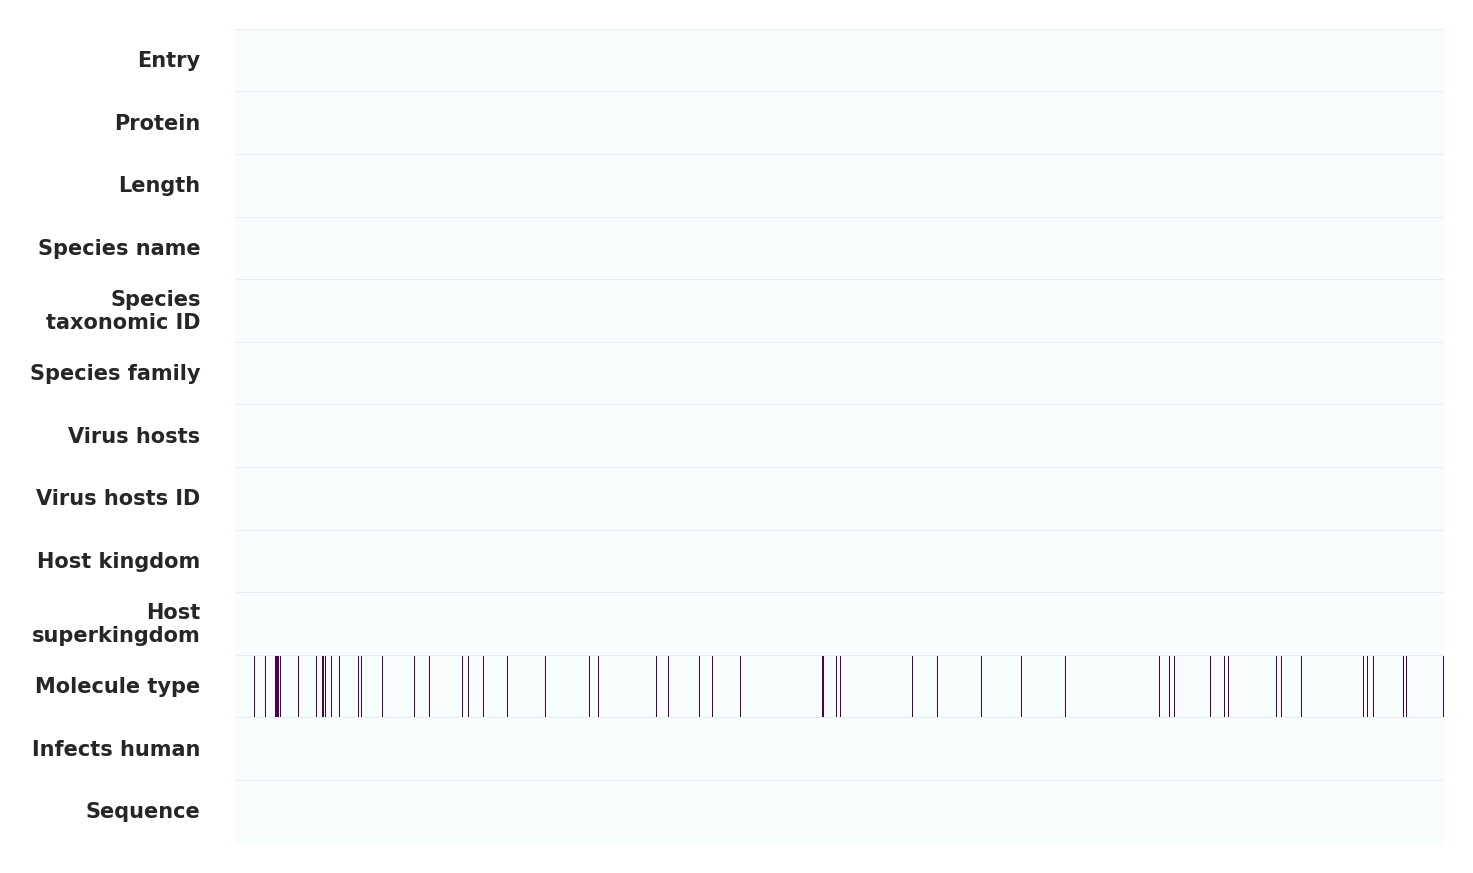

In [573]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(5,3), dpi=300)

ax = sns.heatmap(df.T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)
# ax.set_title("Missing values in the dataset after processing", fontdict=title_params)
ax.set_yticklabels(tick_labels, fontsize=5, fontweight='bold')

plt.tight_layout()
plt.savefig("../assets/Processed_heatmap.png")

In [574]:
df['Molecule type'] = np.where(df['Molecule type'].isna(), 'unknown', df['Molecule type'])

In [575]:
df[df['Host kingdom'].str.contains('Metazoa')][df[df['Host kingdom'].str.contains('Metazoa')]['Molecule type']
                                               .str.contains('DNA')].shape

(31523, 13)

In [576]:
df[df['Host kingdom'].str.contains('Metazoa')][df[df['Host kingdom'].str.contains('Metazoa')]['Molecule type']
                                               .str.contains('RNA')].shape

(273086, 13)

In [577]:
df.shape

(317557, 13)

In [578]:
df[~df['Host kingdom'].str.contains('Metazoa')].shape

(10233, 13)

In [579]:
df[(df['Host superkingdom'].isin(['Bacteria', 'Viruses', 'Archaea'])) |
   (df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens'))].shape

(283445, 13)

In [580]:
unfiltered = df.copy()

metazoa = df[df['Host kingdom'].str.contains('Metazoa')].copy()

plant_human = df[(df['Host kingdom'].str.contains('Viridiplantae')) |
                 df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens')].copy()

NonEukaryote_Human = df[(df['Host superkingdom'].isin(['Bacteria', 'Viruses', 'Archaea'])) |
                        (df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens'))].copy()

DNA_MetazoaZoonosis = metazoa[metazoa['Molecule type'].str.contains('DNA')].copy()

RNA_MetazoaZoonosis = metazoa[metazoa['Molecule type'].str.contains('RNA')].copy()

In [581]:
df.groupby("Infects human").agg(lambda x: len(set(x)))

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Sequence
Infects human,,,,,,,,,,,,
human-false,38768,871,1649.0,4390,4390,77,1405,1405,375,6,12,38768
human-true,278789,319,1278.0,346,346,33,145,143,2,1,11,278789


In [582]:
def check_dist(df):
    true_count = df[df['Infects human'].str.contains('true')].shape[0]
    false_count = df[df['Infects human'].str.contains('false')].shape[0]
    imb = (false_count/true_count)
    print('The minoity class is %.2f of the majority\nhuman-true == %d and human false == %d\n' % (imb, true_count, false_count))

In [583]:
dataframes = [metazoa, unfiltered, plant_human, NonEukaryote_Human, DNA_MetazoaZoonosis, RNA_MetazoaZoonosis]
for dt in dataframes:
    check_dist(dt)

The minoity class is 0.10 of the majority
human-true == 278755 and human false == 28569

The minoity class is 0.14 of the majority
human-true == 278789 and human false == 38768

The minoity class is 0.02 of the majority
human-true == 278789 and human false == 5748

The minoity class is 0.02 of the majority
human-true == 278755 and human false == 4690

The minoity class is 0.29 of the majority
human-true == 24518 and human false == 7005

The minoity class is 0.07 of the majority
human-true == 254068 and human false == 19018



In [584]:
# df.head()

In [585]:
# pd.melt(df.sample(100), value_vars="Infects human")

In [586]:
df["Molecule type"].unique()

array(['ssRNA(+)', 'ssRNA(-)', 'dsDNA', 'ssRNA-RT', 'unknown',
       'ssRNA(+/-)', 'ssDNA(+/-)', 'dsRNA', 'dsDNA-RT', 'ssDNA(-)',
       'ssDNA', 'RNA'], dtype=object)

## Random Undersampling of datasets

In [587]:
seed = 960505

In [588]:
# Undersample majority class such that minority class (human-false) is 60% of the majority class (human-true317316)
rus = RandomUnderSampler(sampling_strategy=0.67, random_state=seed)
sampled_dataframes = []
for dt in dataframes:
    clas = dt['Infects human']
#     print('Dataframe before sampling: ', dt.shape[0])
    dt, _ = rus.fit_resample(dt, clas)
    sampled_dataframes.append(dt)
    check_dist(dt)
#     print('Dataframe after sampling: ', dt.shape[0])

The minoity class is 0.67 of the majority
human-true == 42640 and human false == 28569

The minoity class is 0.67 of the majority
human-true == 57862 and human false == 38768

The minoity class is 0.67 of the majority
human-true == 8579 and human false == 5748

The minoity class is 0.67 of the majority
human-true == 7000 and human false == 4690

The minoity class is 0.67 of the majority
human-true == 10455 and human false == 7005

The minoity class is 0.67 of the majority
human-true == 28385 and human false == 19018



In [589]:
metazoaFile = 'MetazoaZoonosis'
plant_humanFile = 'Plant-HumanZoonosis'
unfilteredFile = 'Zoonosis'
NonEukaryote_HumanFile = 'NonEukaryote-Human'
DNA_metazoaFile = 'DNA-MetazoaZoonosis'
RNA_metazoaFile = 'RNA-MetazoaZoonosis'

## Same order as dataframes
files = [metazoaFile, unfilteredFile, plant_humanFile,
         NonEukaryote_HumanFile, DNA_metazoaFile, RNA_metazoaFile]

In [590]:
def something(df, which):
    proteins = "Protein"
    hosts = "Virus hosts"
    status = "Infects human"
    vals = [proteins, hosts, status]
    
    df = (df.set_index(df.columns.drop('Virus hosts', 1).tolist())['Virus hosts'].str.split('; ', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Virus hosts'})
          .loc[:, df.columns]
         ).copy()
    
    data = pd.pivot_table(df, values=vals,
                               index="Species name",
                               aggfunc={
                                   which: lambda x: len(set(x)),
                                   status: 'first',
                               }
        )
    
    
    print(data.nlargest(3, which), end="\n\n")

In [591]:
something(dataframes[4], "Protein")

                Infects human  Protein
Species name                          
Vaccinia virus     human-true       61
Variola virus      human-true       23
Monkeypox virus    human-true       21



In [592]:
def counts_stripplot(df, label, which, ax):
    proteins = "Protein"
    hosts = "Virus hosts"
    status = "Infects human"
    vals = [proteins, hosts, status]
    
    df = (df.set_index(df.columns.drop('Virus hosts', 1).tolist())['Virus hosts'].str.split('; ', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Virus hosts'})
          .loc[:, df.columns]
         ).copy()
    
    data = pd.pivot_table(df, values=vals,
                               index="Species name",
                               aggfunc={
                                   which: lambda x: len(set(x)),
                                   status: 'first',
                               }
        )
    data.sort_values(by="Infects human", ascending=False, inplace=True)
    
    sns.set_palette("Set1")
    np.random.seed(seed=222)
    sns.stripplot(y=which, x=status, data=data, s=2, ax=ax)
    
    ############# Y-axis #############
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylabel(label, fontsize=5, fontweight='bold', rotation=0)
    ax.yaxis.set_label_coords(0.03, 1.01)

    ############# X-axis #############
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)
    ax.set_xlabel("")
    ax.tick_params(axis='x', pad=0.1)
    
    
    # temporary_list = list()
    # base_count = 0
    # for virus, count in data[which].nlargest(3).to_dict().items():
    #     if (abs(base_count - count) > 3) & (count not in temporary_list):
    #         ax.annotate(
    #             virus,
    #             fontsize=2,
    #             fontweight="bold",
    #             horizontalalignment="right",
    #             verticalalignment="bottom",
    #             xy=(-0.06, count+0.075),
    #             # xycoords='data',
    #             xytext=(0.1, count+0.1)
    #         )
    #     temporary_list.append(count)
    #     base_count=count

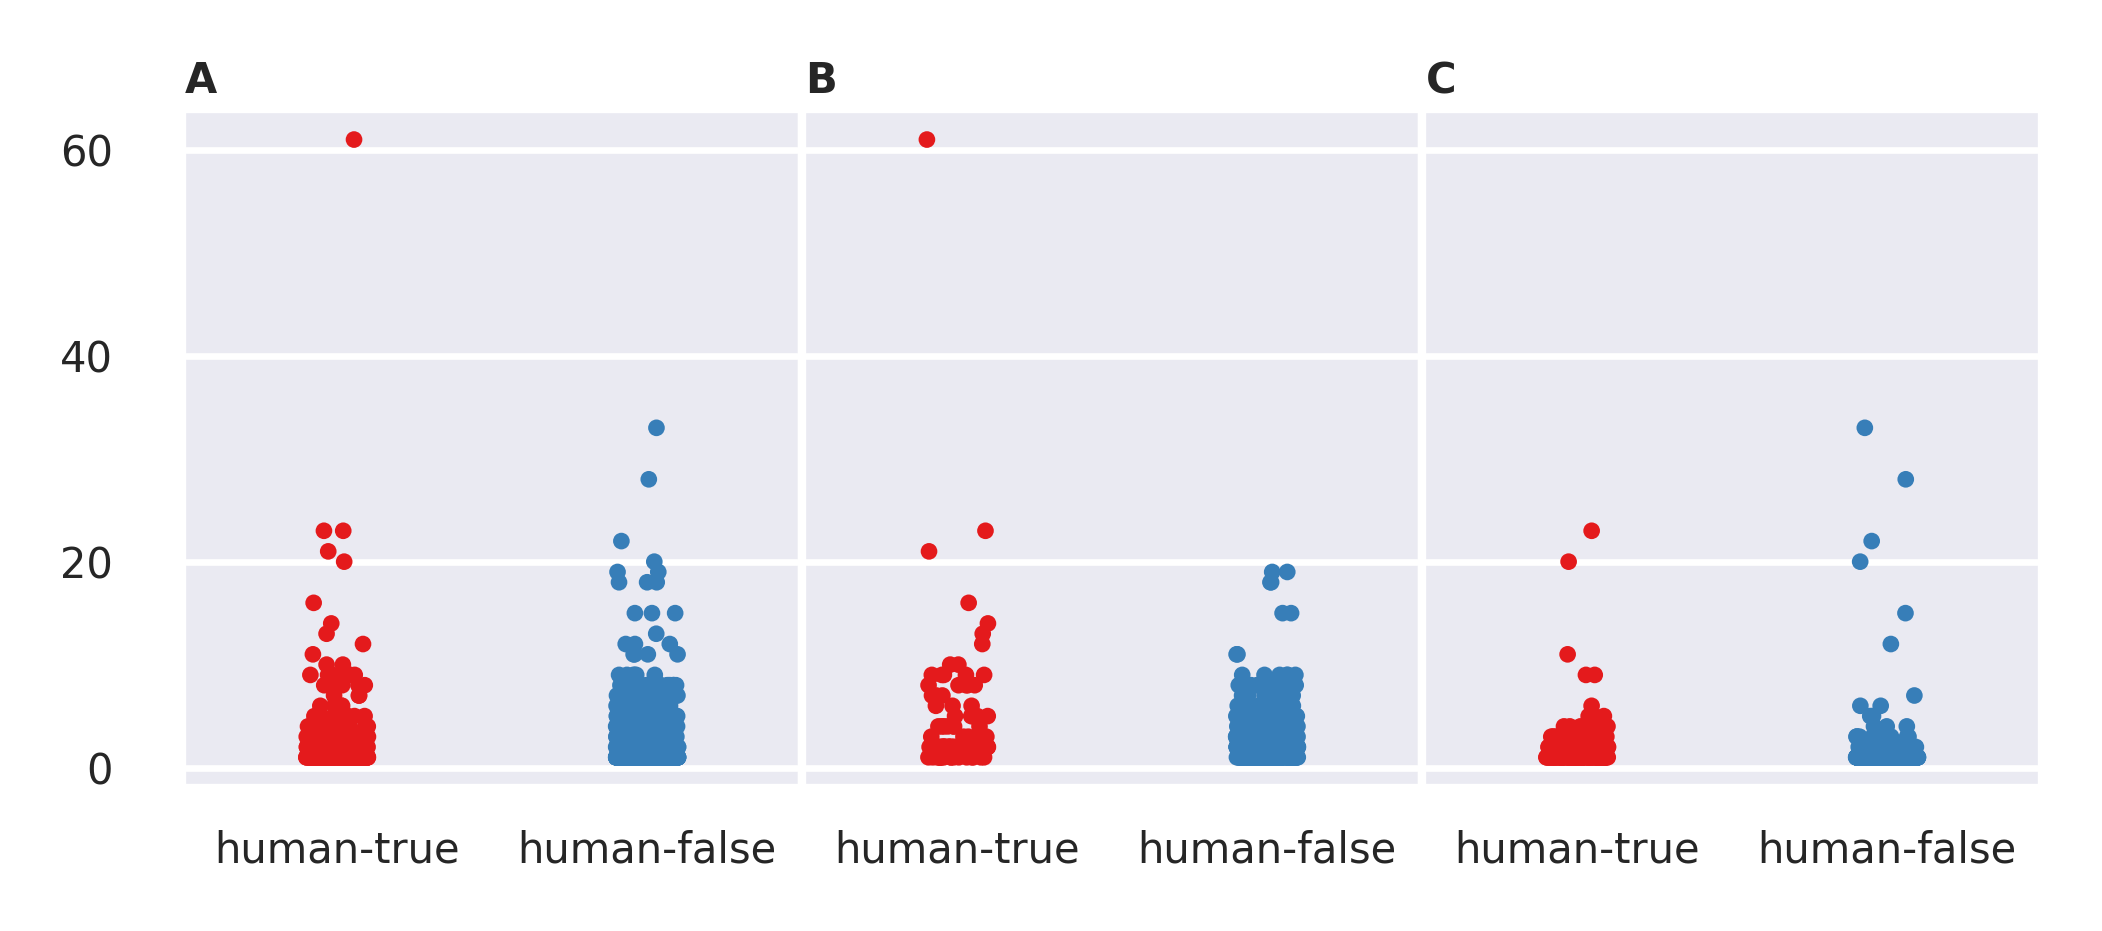

In [593]:
# Protein counts grid
fig, ax = plt.subplots(1, 3, figsize=(4,1.5), dpi=600,
                       constrained_layout=True, sharey=True, sharex=True
                       # gridspec_kw={"wspace":0.0, "hspace":0.0}
)
sns.set_theme(context="paper", style="darkgrid")

# Metazoa, DNA-Metazoa, RNA-Metazoa
counts_stripplot(dataframes[0], "A", "Protein", ax[0])
counts_stripplot(dataframes[4], "B", "Protein", ax[1])
counts_stripplot(dataframes[5], "C", "Protein", ax[2])

plt.subplots_adjust(wspace=0)

plt.savefig("../assets/protein_counts_metazoa_DNA_RNA.png")

In [594]:
something(dataframes[0], "Protein")
something(dataframes[4], "Protein")
something(dataframes[5], "Protein")

                           Infects human  Protein
Species name                                     
Vaccinia virus                human-true       61
Avian orthoreovirus          human-false       33
Vesicular stomatitis virus   human-false       28

                Infects human  Protein
Species name                          
Vaccinia virus     human-true       61
Variola virus      human-true       23
Monkeypox virus    human-true       21

                           Infects human  Protein
Species name                                     
Avian orthoreovirus          human-false       33
Vesicular stomatitis virus   human-false       28
Hepatitis delta virus         human-true       23



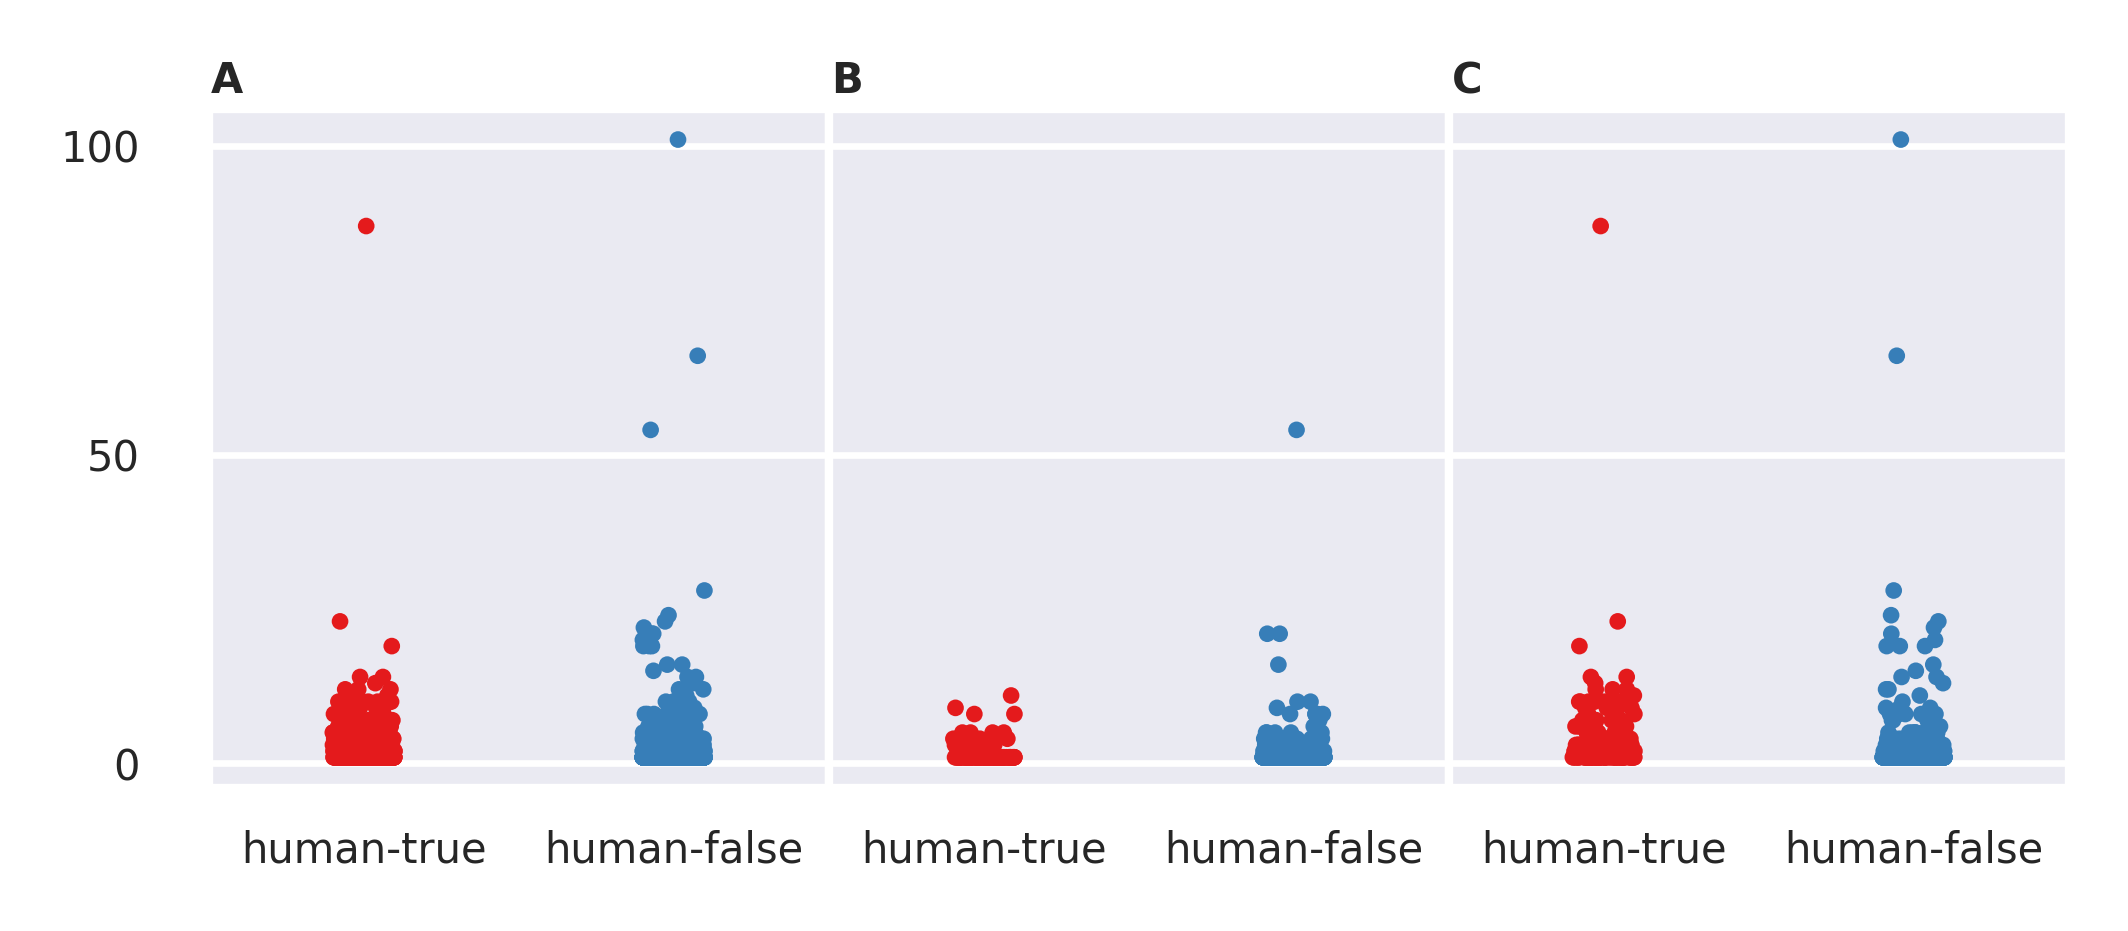

In [595]:
# Host counts grid
fig, ax = plt.subplots(1, 3, figsize=(4,1.5), dpi=600,
                       constrained_layout=True, sharey=True,
                       # gridspec_kw={"wspace":0.0}
)
sns.set_theme(context="paper", style="darkgrid")

# Metazoa, DNA-Metazoa, RNA-Metazoa
counts_stripplot(dataframes[0], "A", "Virus hosts", ax[0])
counts_stripplot(dataframes[4], "B", "Virus hosts", ax[1])
counts_stripplot(dataframes[5], "C", "Virus hosts", ax[2])

plt.subplots_adjust(wspace=0)

plt.savefig("../assets/host_counts_metazoa_DNA_RNA.png")

In [596]:
something(dataframes[0], "Virus hosts")
something(dataframes[4], "Virus hosts")
something(dataframes[5], "Virus hosts")

                  Infects human  Virus hosts
Species name                                
Bat coronavirus     human-false          101
Mamastrovirus sp.    human-true           87
Bat paramyxovirus   human-false           66

                         Infects human  Virus hosts
Species name                                       
Bat mastadenovirus         human-false           54
Bat polyomavirus           human-false           21
Ovine gammaherpesvirus 2   human-false           21

                  Infects human  Virus hosts
Species name                                
Bat coronavirus     human-false          101
Mamastrovirus sp.    human-true           87
Bat paramyxovirus   human-false           66



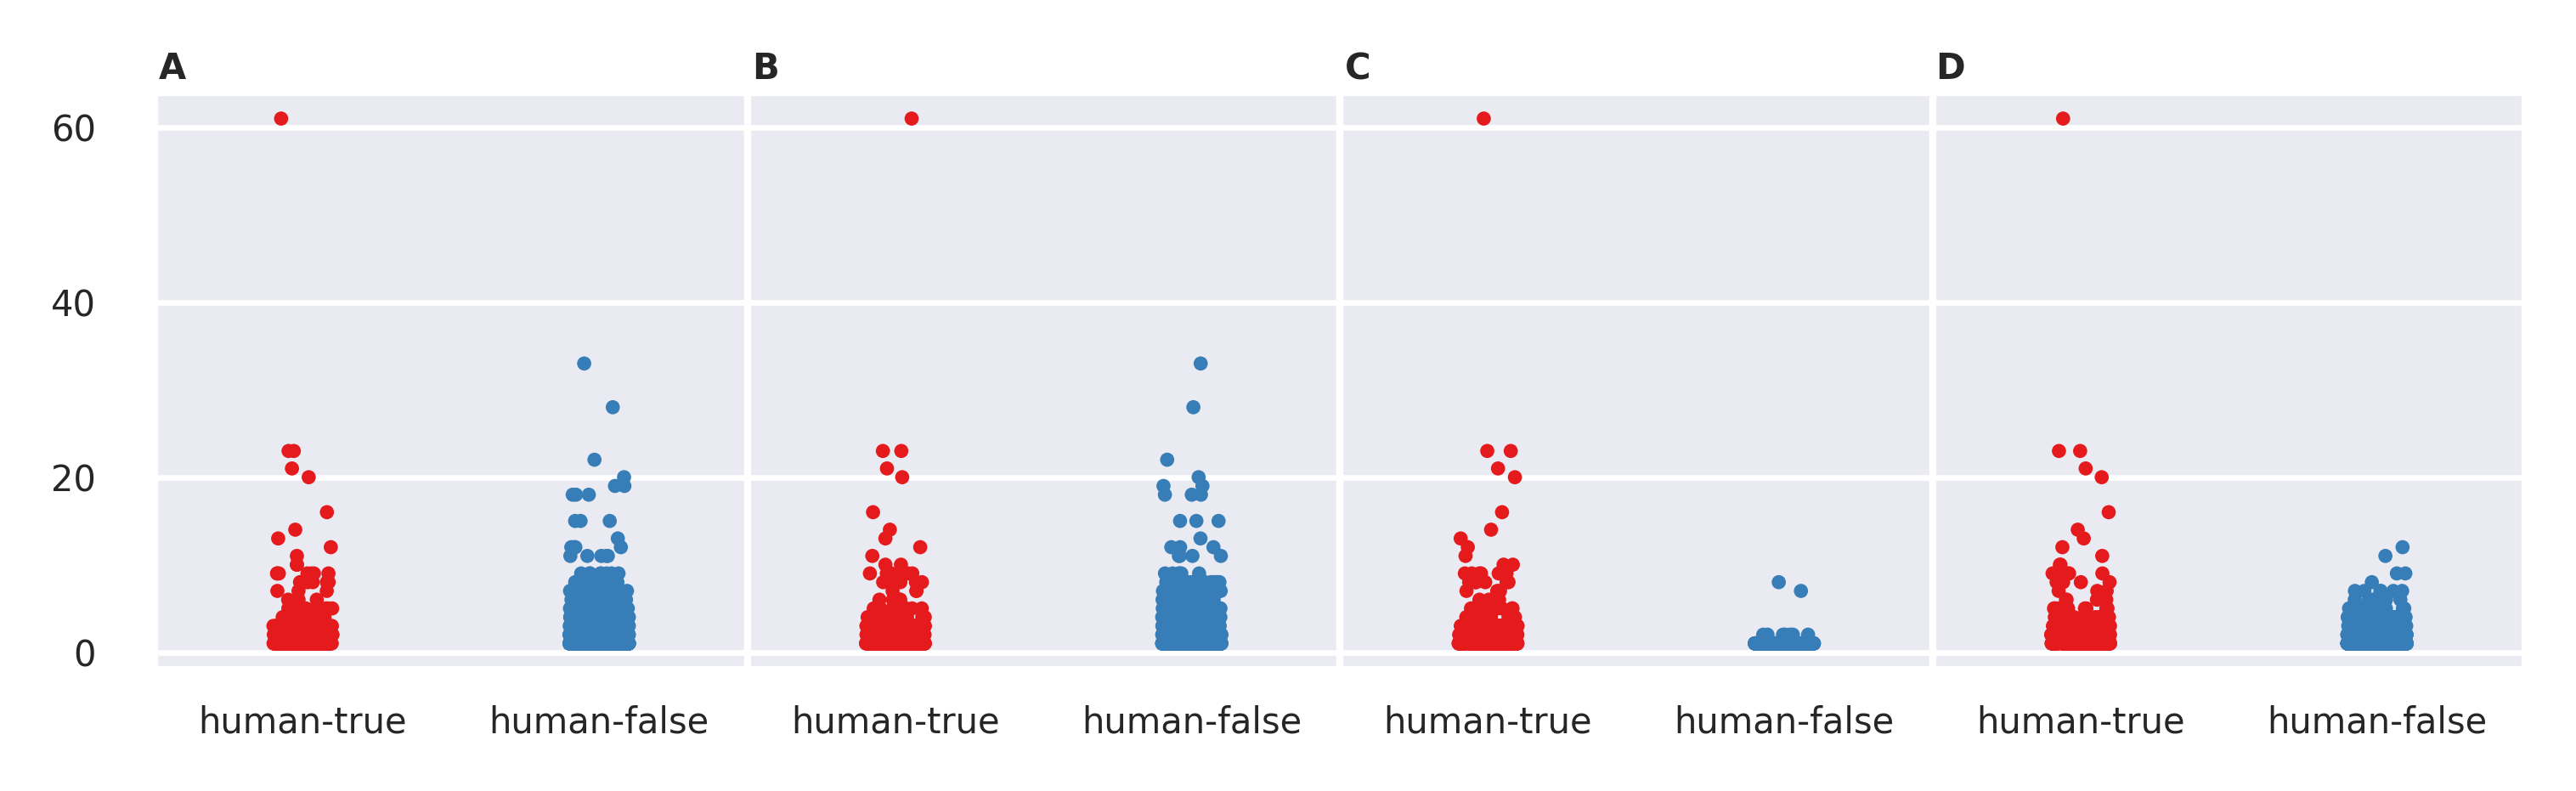

In [597]:
fig, ax = plt.subplots(1, 4, figsize=(6,1.5), dpi=600,
                       constrained_layout=True, sharey=True,
                       # gridspec_kw={"wspace":0.0}
)
sns.set_theme(context="paper", style="darkgrid")

# ZoonoPred, Metazoa, Plant-Human, Non_Eukaryote-Human
counts_stripplot(dataframes[1], "A", "Protein", ax[0])
counts_stripplot(dataframes[0], "B", "Protein", ax[1])
counts_stripplot(dataframes[2], "C", "Protein", ax[2])
counts_stripplot(dataframes[3], "D", "Protein", ax[3])

plt.subplots_adjust(wspace=0)

plt.savefig("../assets/protein_counts_comparison.png")

In [598]:
something(dataframes[1], "Protein")
something(dataframes[0], "Protein")
something(dataframes[2], "Protein")
something(dataframes[3], "Protein")

                           Infects human  Protein
Species name                                     
Vaccinia virus                human-true       61
Avian orthoreovirus          human-false       33
Vesicular stomatitis virus   human-false       28

                           Infects human  Protein
Species name                                     
Vaccinia virus                human-true       61
Avian orthoreovirus          human-false       33
Vesicular stomatitis virus   human-false       28

                      Infects human  Protein
Species name                                
Vaccinia virus           human-true       61
Hepatitis delta virus    human-true       23
Variola virus            human-true       23

                      Infects human  Protein
Species name                                
Vaccinia virus           human-true       61
Hepatitis delta virus    human-true       23
Variola virus            human-true       23



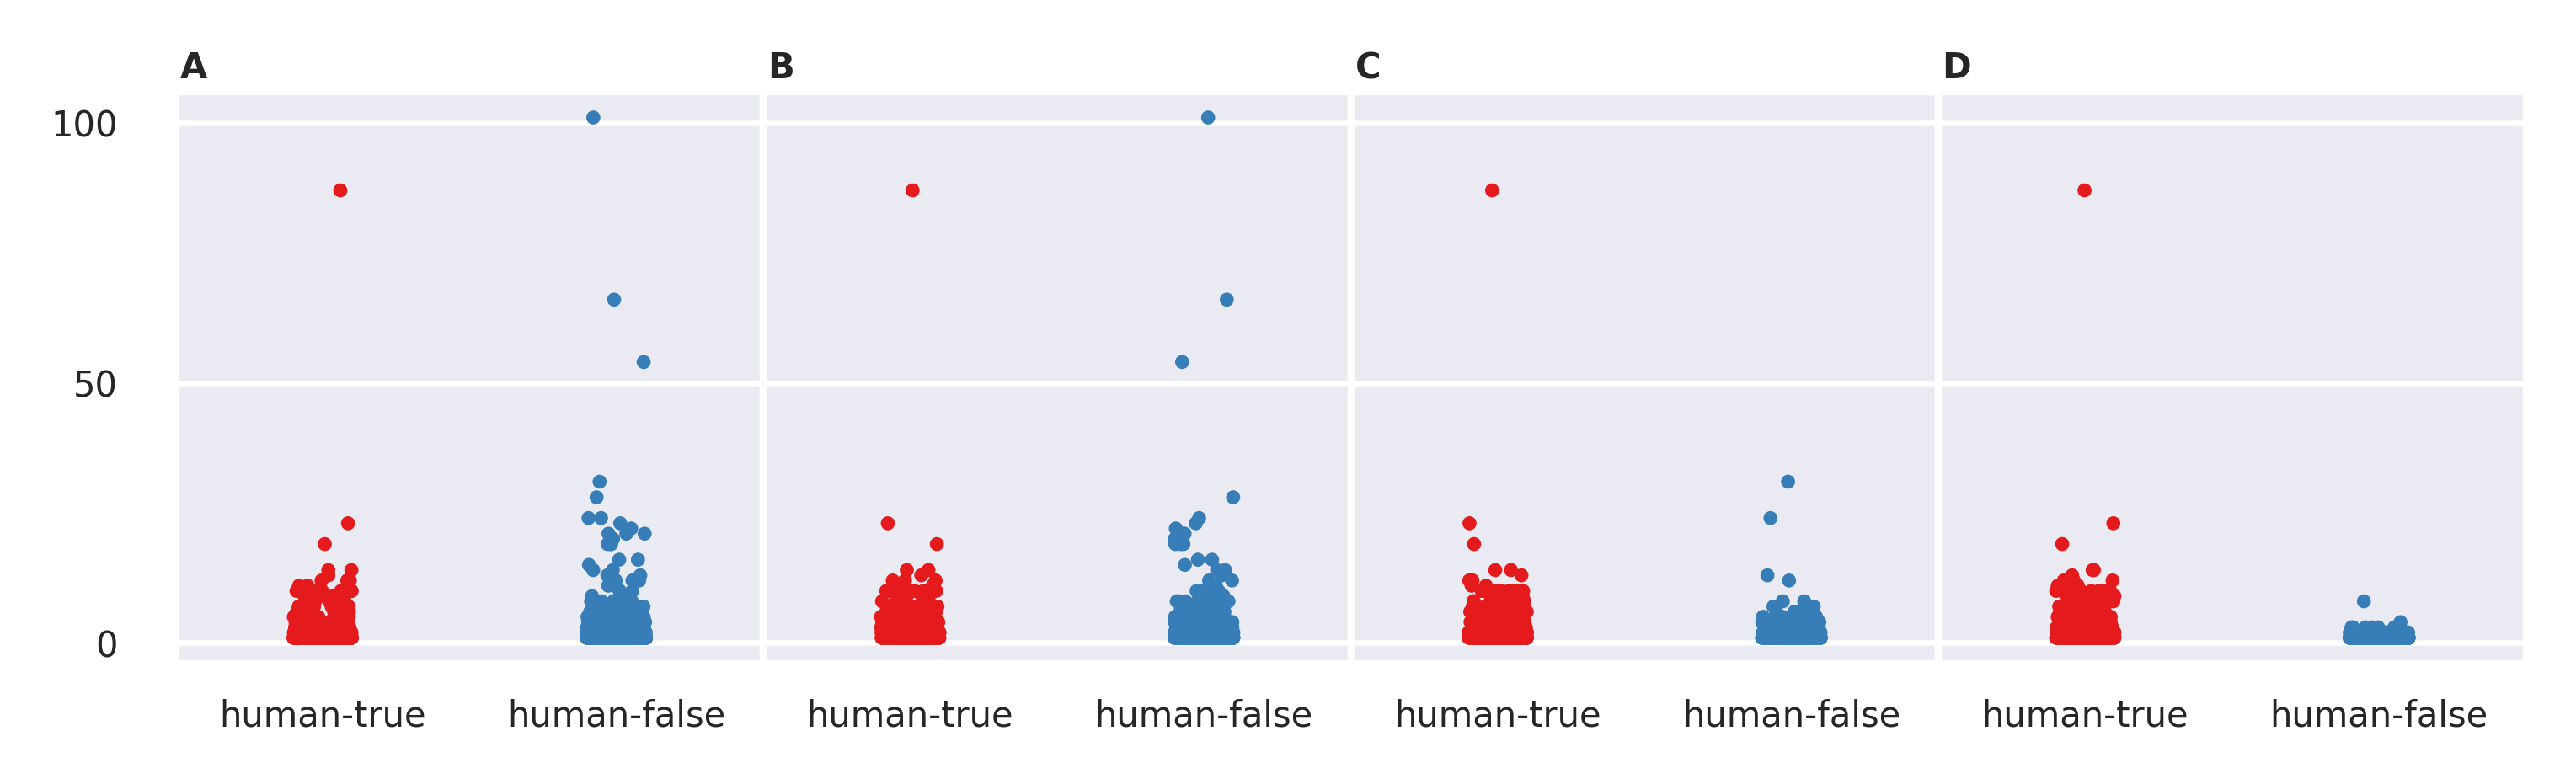

In [599]:
fig, ax = plt.subplots(1, 4, figsize=(6,1.5), dpi=600,
                       constrained_layout=True, sharey=True,
                       # gridspec_kw={"wspace":0.0}
)
sns.set_theme(context="paper", style="darkgrid")

# ZoonoPred, Metazoa, Plant-Human, Non_Eukaryote-Human
counts_stripplot(dataframes[1], "A", "Virus hosts", ax[0])
counts_stripplot(dataframes[0], "B", "Virus hosts", ax[1])
counts_stripplot(dataframes[2], "C", "Virus hosts", ax[2])
counts_stripplot(dataframes[3], "D", "Virus hosts", ax[3])

plt.subplots_adjust(wspace=0)

plt.savefig("../assets/host_counts_comparison.png")

In [600]:
something(dataframes[1], "Virus hosts")
something(dataframes[0], "Virus hosts")
something(dataframes[2], "Virus hosts")
something(dataframes[3], "Virus hosts")

                  Infects human  Virus hosts
Species name                                
Bat coronavirus     human-false          101
Mamastrovirus sp.    human-true           87
Bat paramyxovirus   human-false           66

                  Infects human  Virus hosts
Species name                                
Bat coronavirus     human-false          101
Mamastrovirus sp.    human-true           87
Bat paramyxovirus   human-false           66

                                  Infects human  Virus hosts
Species name                                                
Mamastrovirus sp.                    human-true           87
Melon yellow spot orthotospovirus   human-false           31
Maize streak virus                  human-false           24

                      Infects human  Virus hosts
Species name                                    
Mamastrovirus sp.        human-true           87
Mogiana tick virus       human-true           23
Andes orthohantavirus    human-true           

In [601]:
files

['MetazoaZoonosis',
 'Zoonosis',
 'Plant-HumanZoonosis',
 'NonEukaryote-Human',
 'DNA-MetazoaZoonosis',
 'RNA-MetazoaZoonosis']

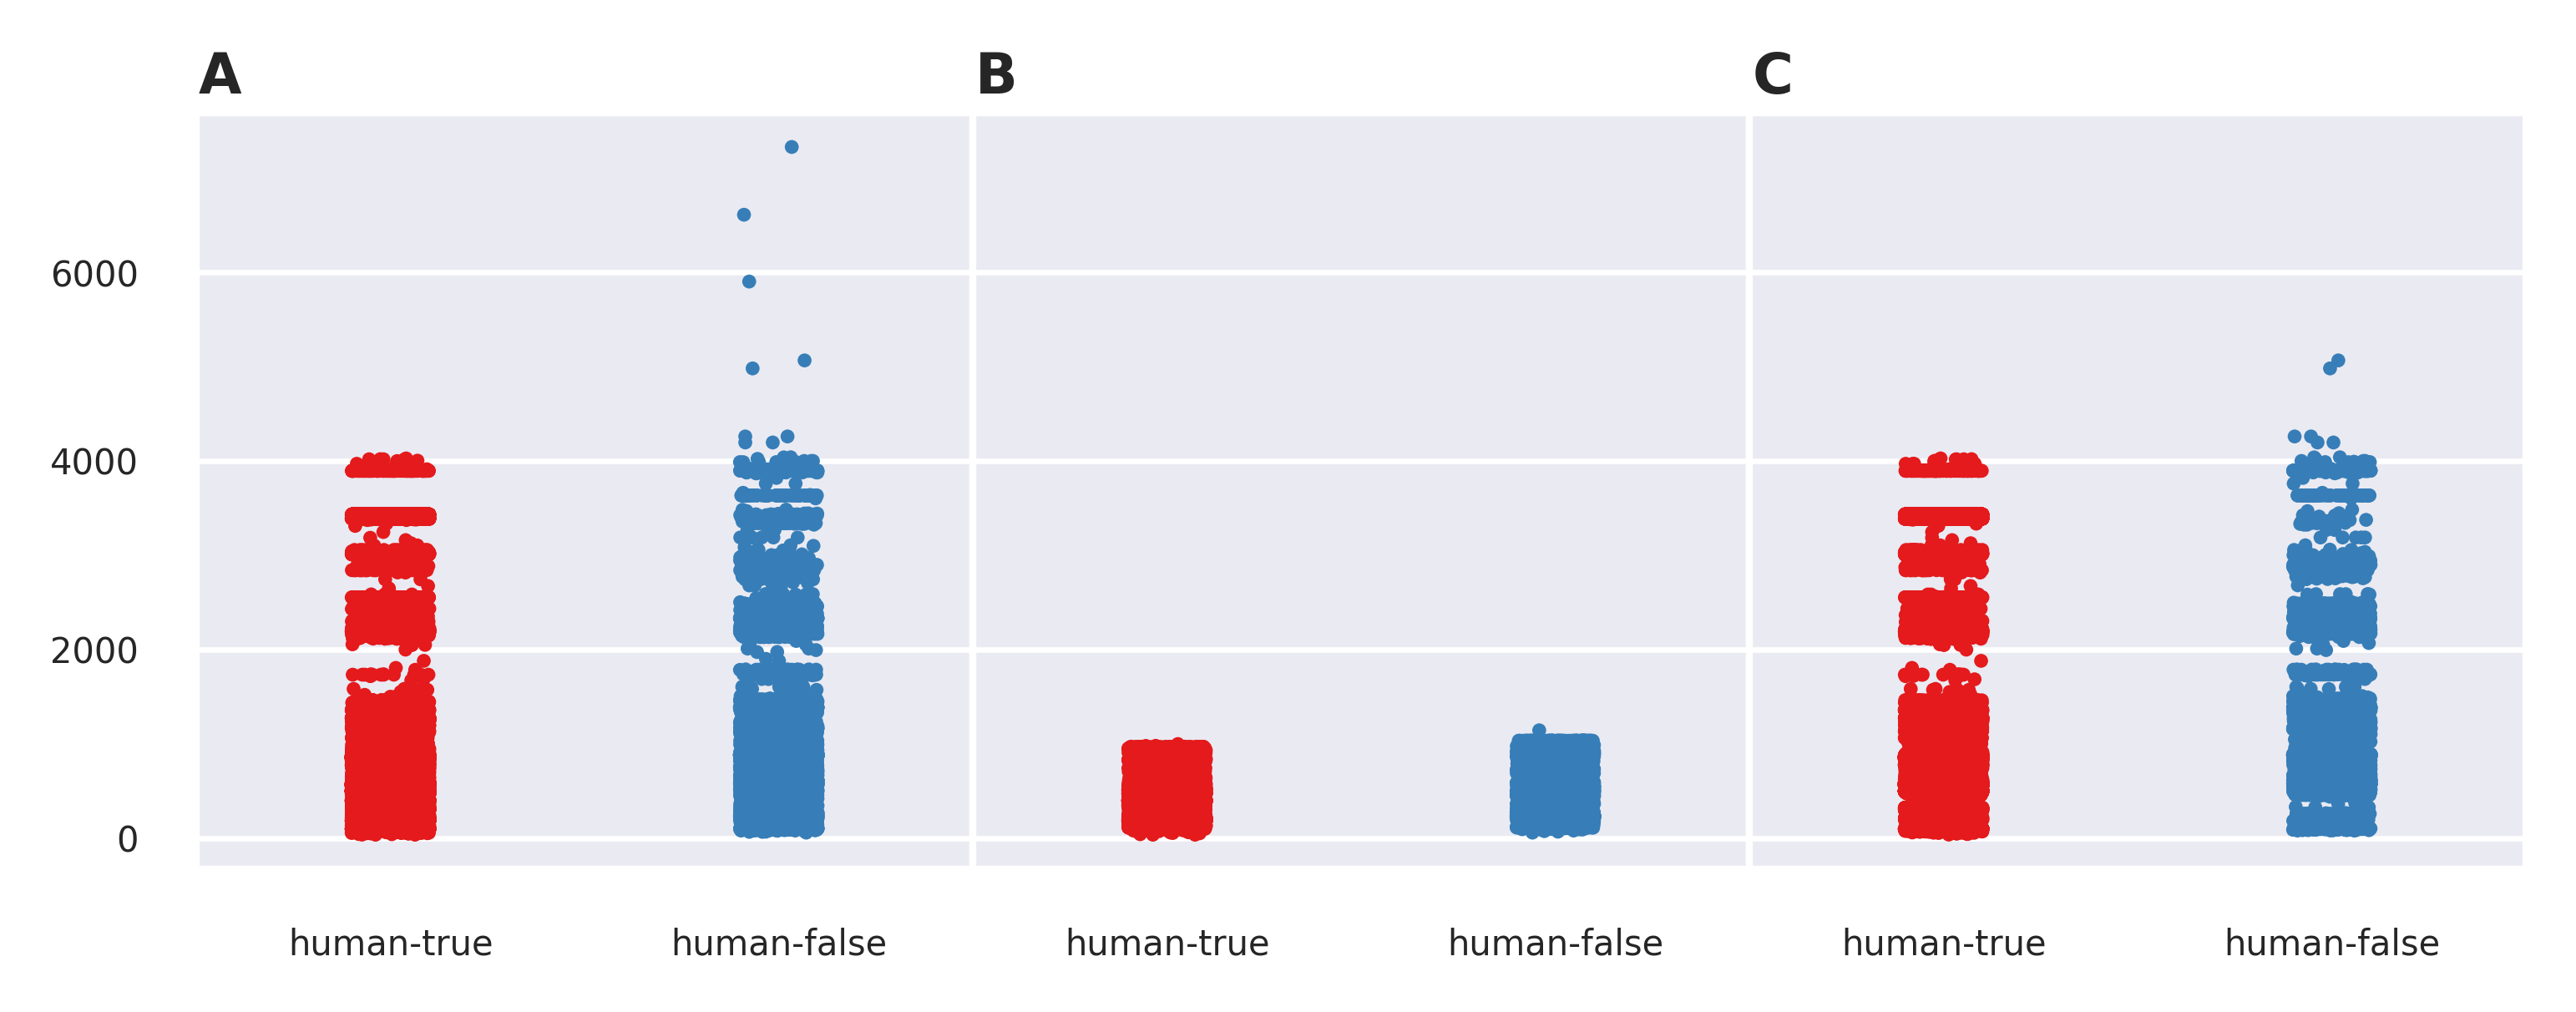

In [602]:
fig = plt.figure(dpi=600, figsize=(6,2), constrained_layout=True)
sns.set_theme("paper", "darkgrid", "Set1")


gs = GridSpec(1,3, wspace=0)

######################################################################################

ax1 = fig.add_subplot(gs[0])
np.random.seed(seed=222)
sns.stripplot(data=dataframes[0], x="Infects human", y="Length", s=2)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=5)
ax1.set_ylabel("A", fontsize=8, fontweight='bold', rotation=0)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

######################################################################################

ax2 = fig.add_subplot(gs[1], sharey=ax1)
np.random.seed(seed=222)
sns.stripplot(data=dataframes[4], x="Infects human", y="Length", s=2)
ax2.set_ylabel("B", fontsize=8, fontweight='bold', rotation=0)
plt.setp(ax2.get_yticklabels(), visible=False)

######################################################################################

ax3 = fig.add_subplot(gs[2], sharey=ax1)
np.random.seed(seed=222)
sns.stripplot(data=dataframes[5], x="Infects human", y="Length", s=2)
ax3.set_ylabel("C", fontsize=8, fontweight='bold', rotation=0)
plt.setp(ax3.get_yticklabels(), visible=False)

######################################################################################

for ax in fig.axes:
    ax.set_xticklabels(ax1.get_xticklabels(), fontsize=5)
    ax.yaxis.set_label_coords(0.03, 1.01)
    ax.set_xlabel("")

plt.savefig(f"../assets/Metazoa_RNA_DNA.png")

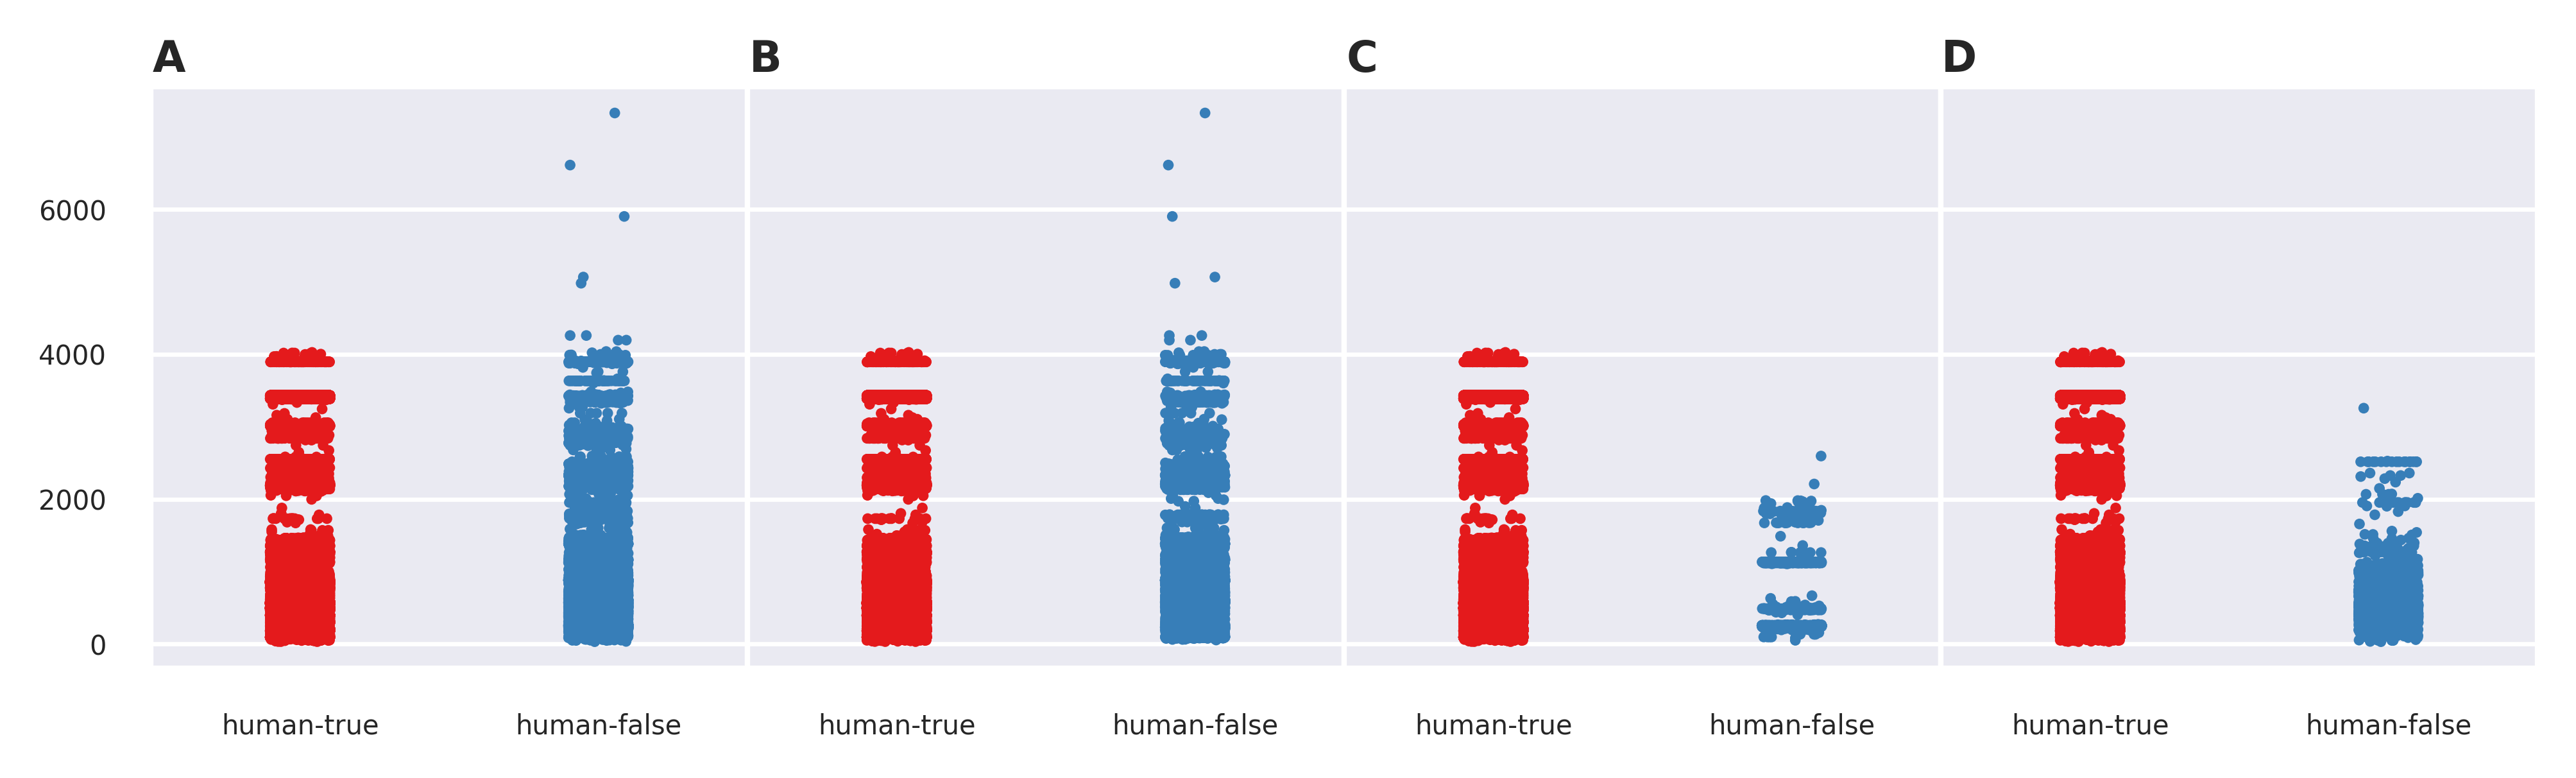

In [603]:
fig = plt.figure(dpi=600, figsize=(8,2), constrained_layout=True)
sns.set_theme("paper", "darkgrid", "Set1")


gs = GridSpec(1,4, wspace=0)

######################################################################################

ax1 = fig.add_subplot(gs[0])
np.random.seed(seed=222)
sns.stripplot(data=dataframes[1], x="Infects human", y="Length", s=2)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=5)
ax1.set_ylabel("A", fontsize=8, fontweight='bold', rotation=0)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

######################################################################################

ax2 = fig.add_subplot(gs[1], sharey=ax1)
np.random.seed(seed=222)
sns.stripplot(data=dataframes[0], x="Infects human", y="Length", s=2)
ax2.set_ylabel("B", fontsize=8, fontweight='bold', rotation=0)
plt.setp(ax2.get_yticklabels(), visible=False)

######################################################################################

ax3 = fig.add_subplot(gs[2], sharey=ax1)
np.random.seed(seed=222)
sns.stripplot(data=dataframes[2], x="Infects human", y="Length", s=2)
ax3.set_ylabel("C", fontsize=8, fontweight='bold', rotation=0)
plt.setp(ax3.get_yticklabels(), visible=False)

######################################################################################

ax4 = fig.add_subplot(gs[3], sharey=ax1)
np.random.seed(seed=222)
sns.stripplot(data=dataframes[3], x="Infects human", y="Length", s=2)
ax4.set_ylabel("D", fontsize=8, fontweight='bold', rotation=0)
plt.setp(ax4.get_yticklabels(), visible=False)

######################################################################################

for ax in fig.axes:
    ax.set_xticklabels(ax1.get_xticklabels(), fontsize=5)
    ax.yaxis.set_label_coords(0.03, 1.01)
    ax.set_xlabel("")

plt.savefig(f"../assets/subset_length_comparison.png")

In [604]:
full_set = pd.DataFrame()

for data, name in zip(dataframes, files):
    data["Subset"] = name
    full_set = full_set.append(data)

full_set.sample(3)

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence,Subset
8230536,W6EVW9,Hexon-interlacing protein,139.0,Human mastadenovirus B,108098,Adenoviridae,Homo sapiens [TaxID: 9606],9606,Metazoa,Eukaryota,dsDNA,human-true,<zoonosis_helper_functions.FASTASeq object at ...,DNA-MetazoaZoonosis
7166677,M4P1Q7,Envelope glycoprotein gp160,849.0,Human immunodeficiency virus 1,11676,Retroviridae,Homo sapiens [TaxID: 9606],9606,Metazoa,Eukaryota,ssRNA-RT,human-true,<zoonosis_helper_functions.FASTASeq object at ...,MetazoaZoonosis
6458562,H2KF87,Hemagglutinin,565.0,Influenza A virus,11320,Orthomyxoviridae,Mustela lutreola [TaxID: 9666]; Sus scrofa [Ta...,9685; 9031; 8782; 9666; 9823; 9694; 9709; 2766...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...,Zoonosis


In [605]:
nucliec_acids_table = (full_set
                       .groupby(["Subset", "Molecule type", "Infects human"])
                       .agg({"Infects human":"size"}))

nucliec_acids_table

Infects human
Subset              Molecule type Infects human               
DNA-MetazoaZoonosis dsDNA         human-false             2911
                                  human-true              9870
                    dsDNA-RT      human-false               35
                                  human-true             14484
                    ssDNA         human-false                1
...                                                        ...
Zoonosis            ssRNA(-)      human-true            156843
                    ssRNA-RT      human-false            10323
                                  human-true             71230
                    unknown       human-false            12745
                                  human-true               203

[92 rows x 1 columns]

In [606]:
nucliec_acids_table.to_csv("../assets/nucliec_acids_table.csv")

In [607]:
df.shape

(317557, 13)

In [608]:
order = ['ssRNA(+)', 'ssRNA(-)', 'dsDNA', 'ssRNA-RT', 'unknown',
       'ssRNA(+/-)', 'ssDNA(+/-)', 'dsRNA', 'dsDNA-RT', 'ssDNA(-)',
       'ssDNA', 'RNA']

In [609]:
def item_sorter(item):
    if item.startswith("ds") or item.startswith("ss"):
        return item[2]
    else:
        return item[1]

In [610]:
order.sort(key = lambda item: item_sorter(item))

In [611]:
def molecule_count_bar(df, ax):
    sns.set_palette("Set1")

    sns.countplot(data=df,
                  y="Molecule type",
                  hue="Infects human",
                  orient="v",
                  order=order,
                  ax=ax
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=5, rotation=90)
    # ax.legend(loc="upper right", fontsize=3)
    ax.get_legend().remove()
    # plt.tight_layout()
    # plt.savefig(f"../assets/{file}/molecue_bar_{file}.png")

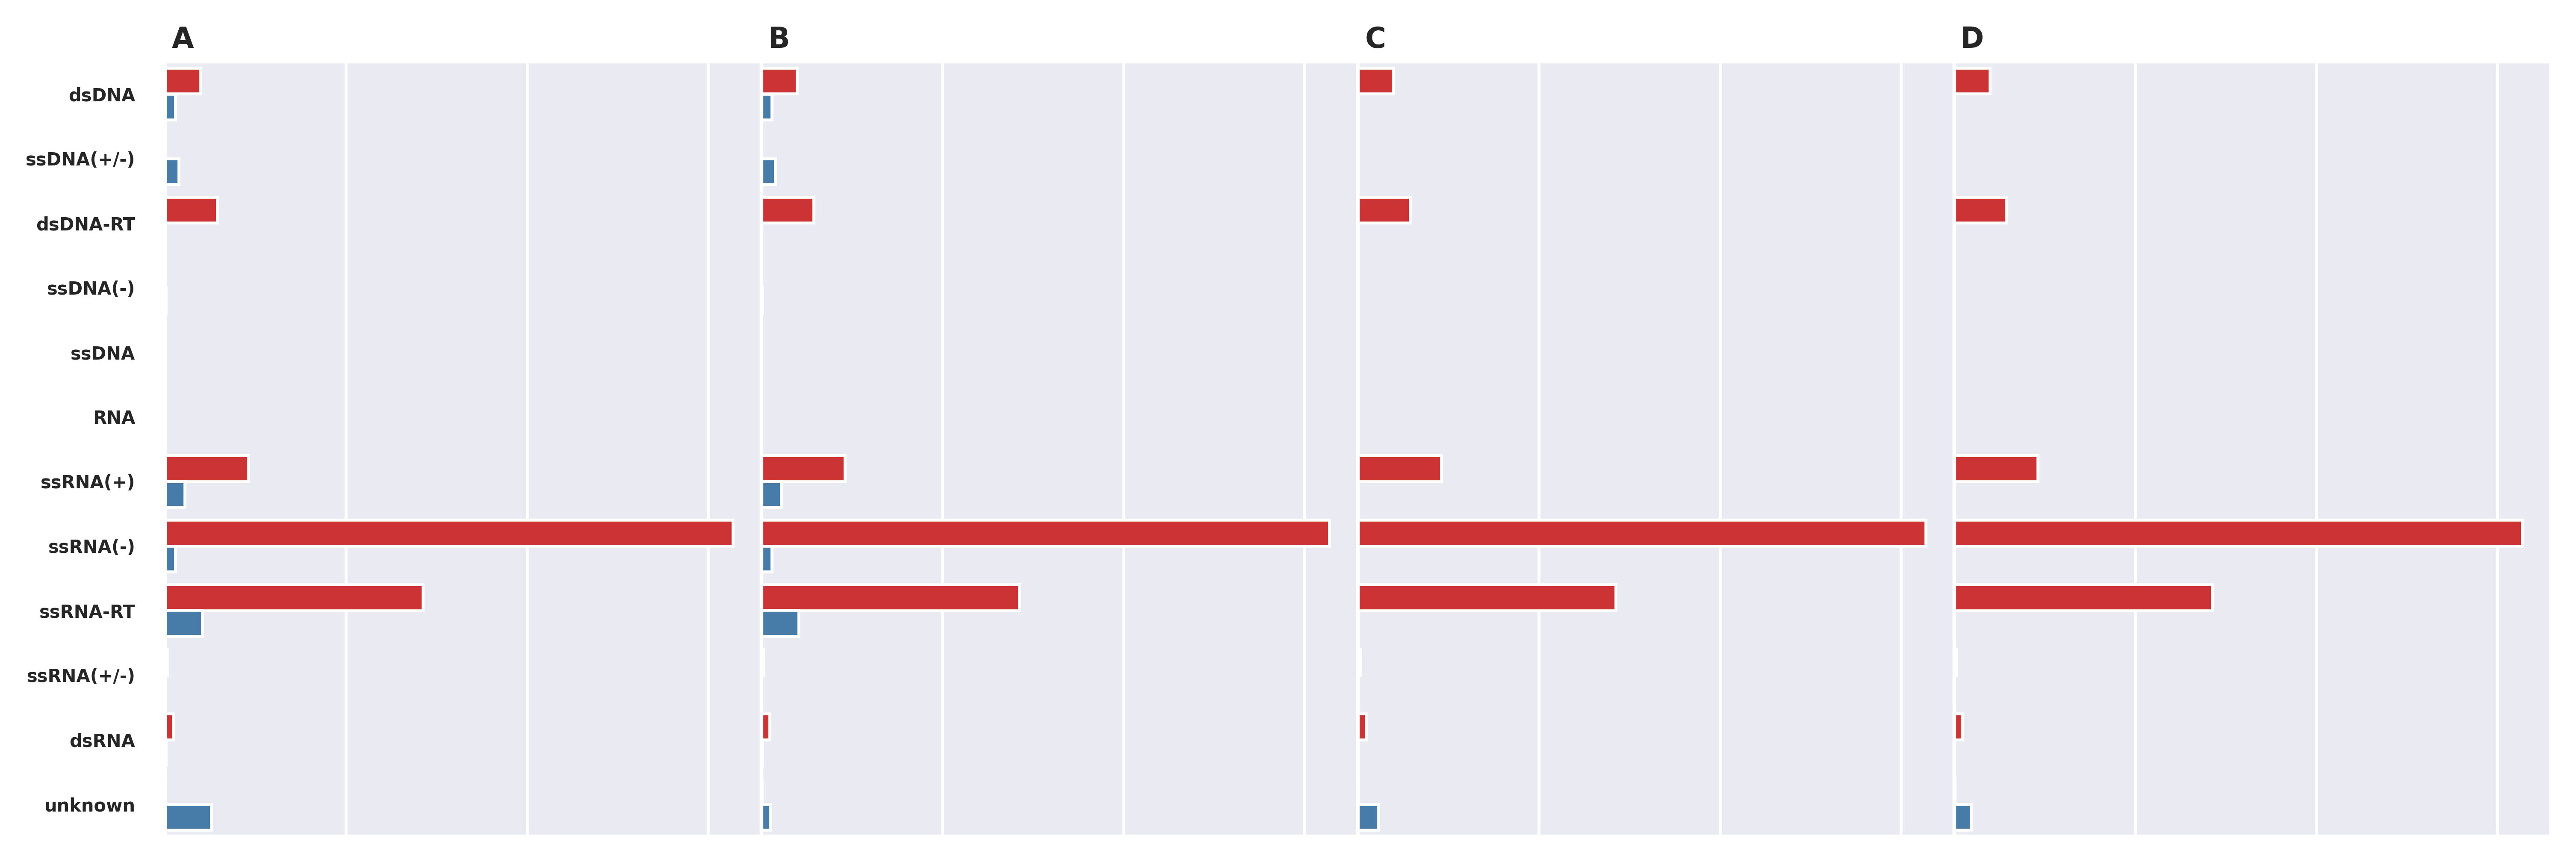

In [612]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4), sharex=True, dpi=600)
sns.set_theme("paper", "darkgrid")

molecule_count_bar(dataframes[1], ax[0])
molecule_count_bar(dataframes[0], ax[1])
molecule_count_bar(dataframes[2], ax[2])
molecule_count_bar(dataframes[3], ax[3])

plt.subplots_adjust(wspace=0)
labels = ["A", "B", "C", "D"]

for label, axes in zip(labels, fig.axes):
    axes.set_yticklabels(axes.get_yticklabels(), fontsize=5, fontweight='bold')
    axes.set_xticklabels([])
    # axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axes.set_ylabel(label, fontsize=8, fontweight='bold', rotation=0)
    axes.yaxis.set_label_coords(0.03, 1.01)
    
    if label != "A":
        plt.setp(axes.get_yticklabels(), visible=False)

plt.savefig("../assets/molecule_bars.png")

## Write file sequences to fasta for feature extraction

In [280]:
## Same order as dataframes
files = [metazoaFile, unfilteredFile, plant_humanFile,
         NonEukaryote_HumanFile, DNA_metazoaFile, RNA_metazoaFile]

dirs = [os.path.join('../data/', fol) for fol in files] # Do not include in script

toSave = list(zip(sampled_dataframes, files, dirs))

In [281]:
equal_full_set = pd.DataFrame()

for df, name in zip(sampled_dataframes, files):
    df["Subset"] = name
    equal_full_set = equal_full_set.append(df)

# equal_full_set.sample(3)

In [282]:
equal_full_set.sample(3)

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence,Subset
23945,P03135,Capsid protein VP1,735.0,Adeno-associated dependoparvovirus A,1511891,Parvoviridae,Mammalia [TaxID: 40674],40674,Metazoa,Eukaryota,ssDNA(+/-),human-false,<zoonosis_helper_functions.FASTASeq object at ...,MetazoaZoonosis
19052,D1G8T2,Envelope glycoprotein gp160,887.0,Simian immunodeficiency virus,11723,Retroviridae,Pan [TaxID: 9596]; Pan troglodytes [TaxID: 959...,9596; 9598; 9527,Metazoa,Eukaryota,ssRNA-RT,human-false,<zoonosis_helper_functions.FASTASeq object at ...,MetazoaZoonosis
66444,A0A3G5NPK8,Protein Vpr,96.0,Human immunodeficiency virus 1,11676,Retroviridae,Homo sapiens [TaxID: 9606],9606,Metazoa,Eukaryota,ssRNA-RT,human-true,<zoonosis_helper_functions.FASTASeq object at ...,Zoonosis


In [283]:
full_sample =  (full_set.groupby(["Subset", "Infects human"])
                .agg({"Infects human": "size"})
                .rename({"Infects human":"Counts"}, axis=1)
                .copy())

undersampled = (equal_full_set.groupby(["Subset", "Infects human"])
                .agg({"Infects human": "size"})
                .rename({"Infects human":"Counts"}, axis=1)
                .copy())

In [284]:
full_sample.merge(undersampled, left_index=True, right_index=True).to_csv("../assets/dataset_sample_counts.csv")

<a id="splits"></a>

In [203]:
# for dff, file, folder in toSave:
#     # Create subdirectories
#     # os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
#     # os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
#     os.makedirs(os.path.join(folder, 'train/'), exist_ok=True)
#     os.makedirs(os.path.join(folder, 'test/'), exist_ok=True)

#     # save dataframes as csv
#     dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')
    
#     # Split data to train and test data
#     train, test = train_test_split(dff, test_size=0.2, random_state=2022) # Will further split 15% of train as validation during training
#     # Save test and train sequences
#     save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
#     save_sequences(test, f'{folder}/test/Sequences')
    
#     print('Done with', file)

In [204]:
# Undersample majority class such that minority class (human-false) is 60% of the majority class (human-true317316)
rus = RandomUnderSampler(sampling_strategy=2/3, random_state=seed)
sampled_dataframes = []
for dt in dataframes:
    clas = dt['Infects human']
#     print('Dataframe before sampling: ', dt.shape[0])
    dt, _ = rus.fit_resample(dt, clas)
    sampled_dataframes.append(dt)
    check_dist(dt)
#     print('Dataframe after sampling: ', dt.shape[0])

The minoity class is 0.67 of the majority
human-true == 42856 and human false == 28571

The minoity class is 0.67 of the majority
human-true == 58155 and human false == 38770

The minoity class is 0.67 of the majority
human-true == 8622 and human false == 5748

The minoity class is 0.67 of the majority
human-true == 7035 and human false == 4690

The minoity class is 0.67 of the majority
human-true == 10507 and human false == 7005

The minoity class is 0.67 of the majority
human-true == 28530 and human false == 19020



In [284]:
%%time

folder = "/scratch2/users/rserage/ZoonosisFull"
dff = unfiltered
file = 'ZoonosisFull'
# Create subdirectories
# os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
# os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=222) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')

CPU times: user 9.82 s, sys: 521 ms, total: 10.3 s
Wall time: 15.8 s


In [285]:
%%time

rus = RandomUnderSampler(sampling_strategy=1, random_state=seed)
clas = unfiltered['Infects human']
dt, _ = rus.fit_resample(unfiltered, clas)

folder = "/scratch2/users/rserage/ZoonosisOne2One"
dff = dt
file = 'ZoonosisOne2One'
# Create subdirectories
# os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
# os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=222) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')

CPU times: user 3.43 s, sys: 202 ms, total: 3.63 s
Wall time: 3.72 s


In [286]:
%%time

rus = RandomUnderSampler(sampling_strategy=2/3, random_state=seed)
clas = unfiltered['Infects human']
dt, _ = rus.fit_resample(unfiltered, clas)

folder = "/scratch2/users/rserage/ZoonosisTwoThirds"
dff = dt
file = 'ZoonosisTwoThirds'
# Create subdirectories
# os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
# os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=222) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')


CPU times: user 4.12 s, sys: 189 ms, total: 4.31 s
Wall time: 4.44 s
